In [ ]:
import pandas as pd
from sklearn import metrics
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import random
import shap
from matplotlib.patches import Patch

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<h3>Loading Dataset</h3>

In [ ]:
path = '../Dataset/'
train_data = pd.read_csv(path+'CIC_IOT_2023_balanced_2_class_over_undersampled_train.csv')
train_data.head()

flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0       6.715501         1209.0           12.1     100.5  12.843083   
1      73.462012        44535.2            7.7     191.0  22.985479   
2      60.069321        55779.3            8.8     121.7   6.172632   
3      35.767762      2636791.0            6.0     231.0  72.257795   
4      32.251696        32869.8           10.4      90.0  14.555923   

       Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0  12.843083    0.0              0.0              0.0              0.0  ...   
1  22.985479    0.0              0.0              0.0              0.0  ...   
2   6.172632    0.0              0.0              0.0              0.0  ...   
3  72.257795    0.0              0.0              0.0              0.0  ...   
4  14.555923    0.0              0.0              0.0              0.0  ...   

         Std  Tot size           IAT  Number   Magnitue      Radius  \
0  44.320532      95.4  1.665202e+08    13.5  14.621806   62.742005   
1  27.691995      98.8  6.047893e-03     5.5  13.538316   39.162395   
2  79.439417     184.1  1.706760e-02     5.5  16.367950  112.344300   
3   0.000000      66.0  1.686502e-03     5.5  11.489125    0.000000   
4  17.984090      78.4  1.110640e-02     5.5  11.644900   25.433343   

    Covariance  Variance  Weight  label  
0  1970.908307       1.0   244.6      0  
1  1052.691326       0.9    38.5      0  
2  8626.834264       0.9    38.5      0  
3     0.000000       0.0    38.5      0  
4   444.826374       0.8    38.5      0  

[5 rows x 47 columns]

In [ ]:
train_data = train_data.dropna(axis=0)
len(train_data)

3000000

In [ ]:
train_data['label'].value_counts()

label
1    2000000
0    1000000
Name: count, dtype: int64

In [ ]:
# attack_df1 = train_data[train_data['label']==1]
# attack_df1 = attack_df1.sample(n=min(train_data.label.value_counts()), random_state=42)

# ben_df1 = train_data[train_data['label']==0]
# ben_df1 = ben_df1.sample(n=min(train_data.label.value_counts()), random_state=42)

# train_data = pd.concat([attack_df1, ben_df1], ignore_index=False)
# train_data = train_data.sample(frac=1) #shuffling
# print(train_data['label'].value_counts())
# len(train_data)

In [ ]:
path = '../Dataset/'
test_data = pd.read_csv(path+'CIC_IOT_2023_20%_testing_2.csv')
test_data.head()

flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0       0.000000           0.00           1.00     64.00     1.743276   
1       3.709134     3973168.90          16.61     65.04  1856.581305   
2       0.000000          54.00           6.00     64.00     2.848676   
3       0.000000          53.46           5.95     64.00    10.788210   
4       0.071602          19.94           1.09     65.05     2.096381   

         Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0     1.743276    0.0              0.0              0.0              0.0  ...   
1  1856.581305    0.0              0.0              0.0              0.0  ...   
2     2.848676    0.0              0.0              1.0              0.0  ...   
3    10.788210    0.0              0.0              1.0              0.0  ...   
4     2.096381    0.0              0.0              0.0              0.0  ...   

         Std  Tot size           IAT  Number   Magnitue     Radius  \
0   0.000000     42.00  8.312888e+07     9.5   9.165151   0.000000   
1  62.831747    539.08  8.371155e+07     9.5  32.385592  88.943645   
2   0.000000     54.00  8.309440e+07     9.5  10.392305   0.000000   
3   0.398463     54.44  8.336548e+07     9.5  10.401502   0.566842   
4   3.878586     43.33  8.312837e+07     9.5   9.316268   5.492694   

     Covariance  Variance  Weight  label  
0      0.000000      0.00  141.55      1  
1  11193.731860      0.37  141.55      1  
2      0.000000      0.00  141.55      1  
3      4.018273      0.04  141.55      1  
4    109.917888      0.14  141.55      1  

[5 rows x 47 columns]

In [ ]:
test_data['label'].value_counts()

label
1    9117568
0     219748
Name: count, dtype: int64

In [ ]:
attack_df1 = test_data[test_data['label']==1]
attack_df1 = attack_df1.sample(n=min(test_data.label.value_counts()), random_state=42)

ben_df1 = test_data[test_data['label']==0]
ben_df1 = ben_df1.sample(n=min(test_data.label.value_counts()), random_state=42)

test_data = pd.concat([attack_df1, ben_df1], ignore_index=False)
test_data = test_data.sample(frac=1) #shuffling
len(test_data)

439496

In [ ]:
test_data = test_data.dropna(axis=0)
len(test_data)

439496

In [ ]:
test_data['label'].value_counts()

label
0    219748
1    219748
Name: count, dtype: int64

<h3>Data Preprocessing</h2>

In [ ]:
X_train = train_data.drop(columns=['label'],axis=1).to_numpy()
X_test = test_data.drop(columns=['label'],axis=1).to_numpy()

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
np.unique(y_train)

array([0, 1], dtype=int64)

<h2>Using D-Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=5,class_weight='balanced')

clf.fit(X_train,train_data['label'])

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
print(metrics.accuracy_score(test_data['label'], predicted))
print(classification_report(test_data['label'], predicted))

0.9919817245208148
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    219748
           1       1.00      0.98      0.99    219748

    accuracy                           0.99    439496
   macro avg       0.99      0.99      0.99    439496
weighted avg       0.99      0.99      0.99    439496



In [ ]:
print(metrics.accuracy_score(test_data['label'], predicted))
print(metrics.precision_score(test_data['label'], predicted, average='weighted'))
print(metrics.recall_score(test_data['label'], predicted, average='weighted'))
print(metrics.f1_score(test_data['label'], predicted, average='weighted'))

0.9919817245208148
0.9920954066980773
0.9919817245208148
0.9919812614055074


In [ ]:
print(metrics.precision_score(test_data['label'], predicted, average='macro'))
print(metrics.recall_score(test_data['label'], predicted, average='macro'))
print(metrics.f1_score(test_data['label'], predicted, average='macro'))

0.9920954066980772
0.9919817245208148
0.9919812614055072


In [ ]:
print(metrics.precision_score(test_data['label'], predicted, average='micro'))
print(metrics.recall_score(test_data['label'], predicted, average='micro'))
print(metrics.f1_score(test_data['label'], predicted, average='micro'))

0.9919817245208148
0.9919817245208148
0.9919817245208148


In [ ]:
cm = metrics.confusion_matrix(test_data['label'], predicted)

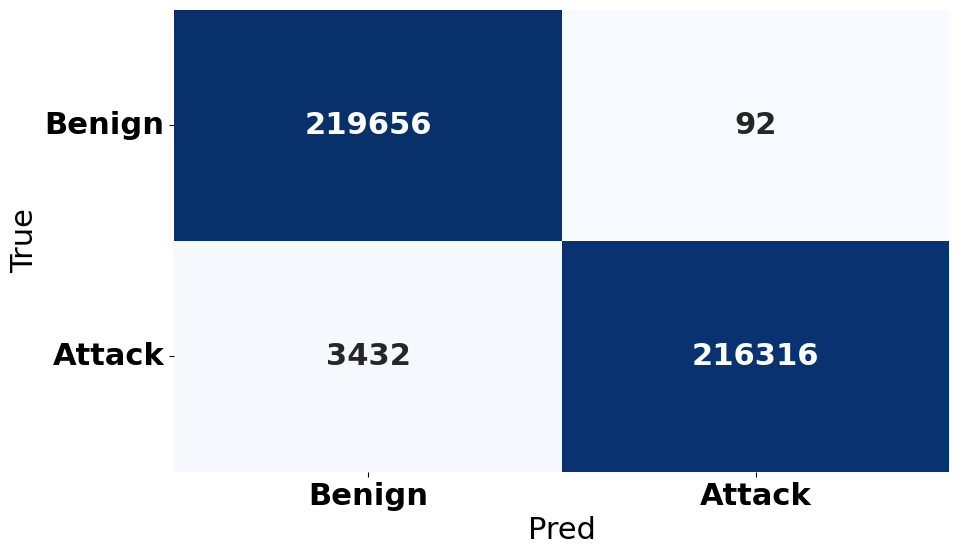

In [ ]:
## Plot confusion matrix
unique_classes = ['Benign','Attack']
fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes,
       yticklabels=unique_classes)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 22,'font.weight':'bold'})
plt.yticks(rotation=0)
plt.show()

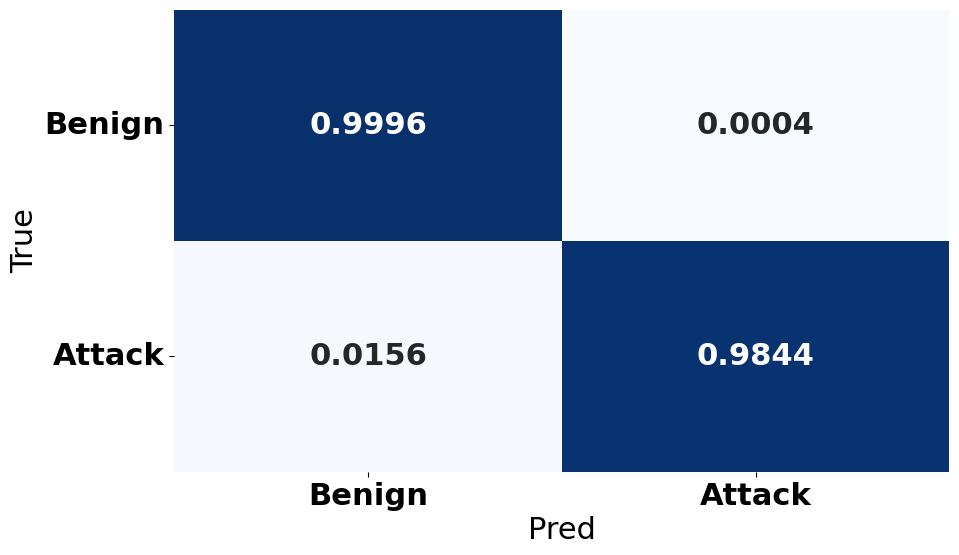

In [ ]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, fmt='.4f', xticklabels=unique_classes,
       yticklabels=unique_classes, cmap=plt.cm.Blues,
            cbar=False)
plt.rcParams["figure.figsize"] = (10,6)
plt.yticks(rotation=0)
plt.ylabel('True')
plt.xlabel('Pred')
plt.show(block=False)

In [ ]:
# Get predicted probabilities for the positive class
y_prob_dt = clf.predict_proba(X_test)[:,1]

# Calculate Brier score for binary classification
brier_score_pos = metrics.brier_score_loss(test_data['label'], y_prob_dt)
print(f'Brier score (binary): {brier_score_pos:.4f}')

Brier score (binary): 0.0079


In [ ]:
import xgboost

In [ ]:
unique_classes = ['Benign','Attack']

In [ ]:
# from sklearn.utils import class_weight
# classes_weights = list(class_weight.compute_class_weight('balanced',
#                                              classes=np.unique(y_train),
#                                              y=y_train))

# weights = np.ones(y_train.shape[0], dtype = 'float')

In [ ]:
# param_dist = {

# 'learning_rate': [0.25, 0.7, 1],

# 'max_depth': [21, 27, 33],

# 'n_estimators': [150, 200, 300],

# 'colsample_bytree': [0.3, 0.5, 0.7],

# 'subsample': [0.5,0.8, 1.0]
# }

In [ ]:
# xgb_classifier = xgboost.XGBClassifier(verbosity=2,objective='binary:logistic')

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, scoring='accuracy', n_iter=10, cv=3, verbose=2)
# random_search.fit(X_train, y_train)

In [ ]:
# print("Best Hyperparameters:", random_search.best_params_)

In [ ]:
xgb_classifier = xgboost.XGBClassifier(objective='binary:logistic', verbosity=2, n_estimators=100, max_depth=5)

In [ ]:
xgb_model = xgb_classifier.fit(X_train, y_train)
xgb_predicted_values = xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test , xgb_predicted_values,target_names=unique_classes))

              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00    219748
      Attack       1.00      0.99      1.00    219748

    accuracy                           1.00    439496
   macro avg       1.00      1.00      1.00    439496
weighted avg       1.00      1.00      1.00    439496



In [ ]:
print(metrics.accuracy_score(y_test, xgb_predicted_values))
print(metrics.precision_score(y_test, xgb_predicted_values, average='weighted'))
print(metrics.recall_score(y_test, xgb_predicted_values, average='weighted'))
print(metrics.f1_score(y_test, xgb_predicted_values, average='weighted'))

0.9968441123468701
0.9968516691574243
0.9968441123468701
0.9968441003470432


In [ ]:
xgb_cm = metrics.confusion_matrix(y_test, xgb_predicted_values)

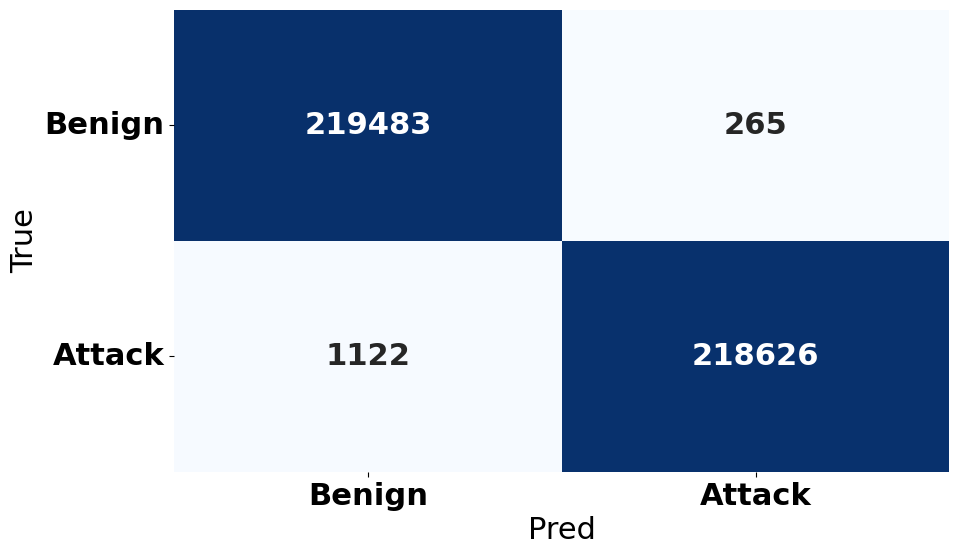

In [ ]:
fig, ax = plt.subplots()
sn.heatmap(xgb_cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes,
       yticklabels=unique_classes)
plt.rcParams["figure.figsize"] = (10,6)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 22,'font.weight':'bold'})
plt.show()

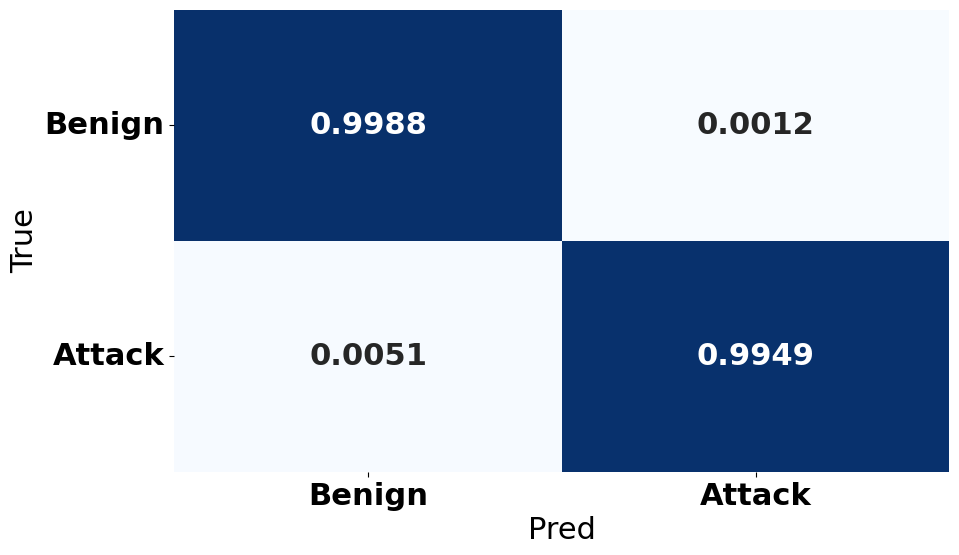

In [ ]:
cm = xgb_cm.astype('float') / xgb_cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, fmt='.4f', xticklabels=unique_classes,
       yticklabels=unique_classes, cmap=plt.cm.Blues,
            cbar=False)
plt.rcParams["figure.figsize"] = (10,6)
plt.yticks(rotation=0)
plt.ylabel('True')
plt.xlabel('Pred')
plt.show(block=False)

In [ ]:
def calculate_fpr_fnr(confusion_matrix):
    """
    Calculate and print the False Positive Rate (FPR) and False Negative Rate (FNR) from a confusion matrix.

    Parameters:
    - confusion_matrix: 2D array-like, the confusion matrix

    Returns:
    - FPR: False Positive Rate
    - FNR: False Negative Rate
    """
    # Extract TN, FP, FN, and TP from the confusion matrix
    TN, FP, FN, TP = confusion_matrix.ravel()

    # Calculate FPR and FNR
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    # Print FPR and FNR
    print(f"False Positive Rate (FPR): {FPR:.4f}")
    print(f"False Negative Rate (FNR): {FNR:.4f}")

    return FPR, FNR



# Confusion matrix values
# xgb_cm = np.array([[219483, 265], [1122, 218626]])

calculate_fpr_fnr(xgb_cm)

# Calculate normalized values for each cell
normalized_cm = xgb_cm.astype('float') / xgb_cm.sum(axis=1)[:, np.newaxis]

# Combine values and normalized values into one string for annotation
annot = np.empty_like(xgb_cm).astype(str)
for i in range(xgb_cm.shape[0]):
    for j in range(xgb_cm.shape[1]):
        annot[i, j] = f"{xgb_cm[i, j]}\n({normalized_cm[i, j]:.2%})"

fig, ax = plt.subplots()
sn.heatmap(xgb_cm, annot=annot, fmt='', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes, yticklabels=unique_classes)
plt.rcParams["figure.figsize"] = (10, 6)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 22, 'font.weight': 'bold'})
plt.show()


In [ ]:
# Get predicted probabilities for the positive class
y_prob = xgb_model.predict_proba(X_test)[:,1]

# Calculate Brier score for binary classification
brier_score_pos = metrics.brier_score_loss(test_data['label'], y_prob)
print(f'Brier score (binary): {brier_score_pos:.4f}')

Brier score (binary): 0.0028


In [ ]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
# data = pd.concat([train_data,test_data]).sample(frac = 1)
# data.head()

In [ ]:
# data.label.value_counts()

In [ ]:
# X, y = data[data.columns[:-1]], data.label

In [ ]:
# num_folds = 5
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
# st_cross_val_results = cross_val_score(xgb_model, X, y, cv=skf)
# print(f'Stratified Cross-Validation Results (Accuracy): {st_cross_val_results}')
# print(f'Mean Accuracy: {st_cross_val_results.mean()}')

# # Stratified Cross-Validation Results (Accuracy): [0.99598924 0.99593981 0.99621892 0.99588893 0.99600959]
# # Mean Accuracy: 0.9960092990426668

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
rf_y_pred = rf_clf.predict(X_test)

In [ ]:
print(classification_report(y_test , rf_y_pred,target_names=unique_classes))

              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    219748
      Attack       1.00      0.98      0.99    219748

    accuracy                           0.99    439496
   macro avg       0.99      0.99      0.99    439496
weighted avg       0.99      0.99      0.99    439496



In [ ]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = metrics.accuracy_score(y_test, rf_y_pred)
precision = metrics.precision_score(y_test, rf_y_pred, average='weighted')
recall = metrics.recall_score(y_test, rf_y_pred, average='weighted')
f1 = metrics.f1_score(y_test, rf_y_pred, average='weighted')

In [ ]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9896950142890948
Precision: 0.989883202506994
Recall: 0.9896950142890948
F1 Score: 0.9896940245311548


In [ ]:
rf_cm = metrics.confusion_matrix(y_test, rf_y_pred)

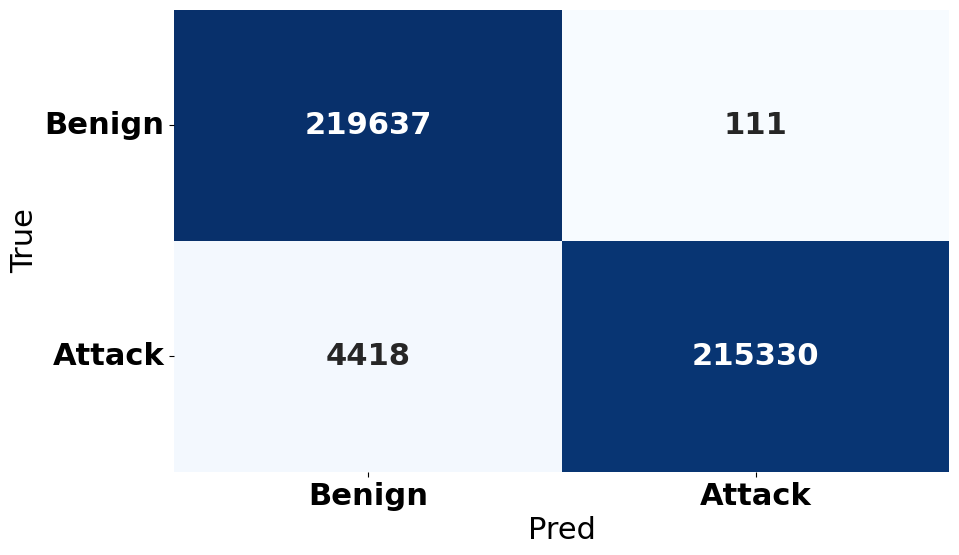

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sn.heatmap(rf_cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes,
       yticklabels=unique_classes)
plt.rcParams["figure.figsize"] = (10,6)
plt.yticks(rotation=0)
plt.show()

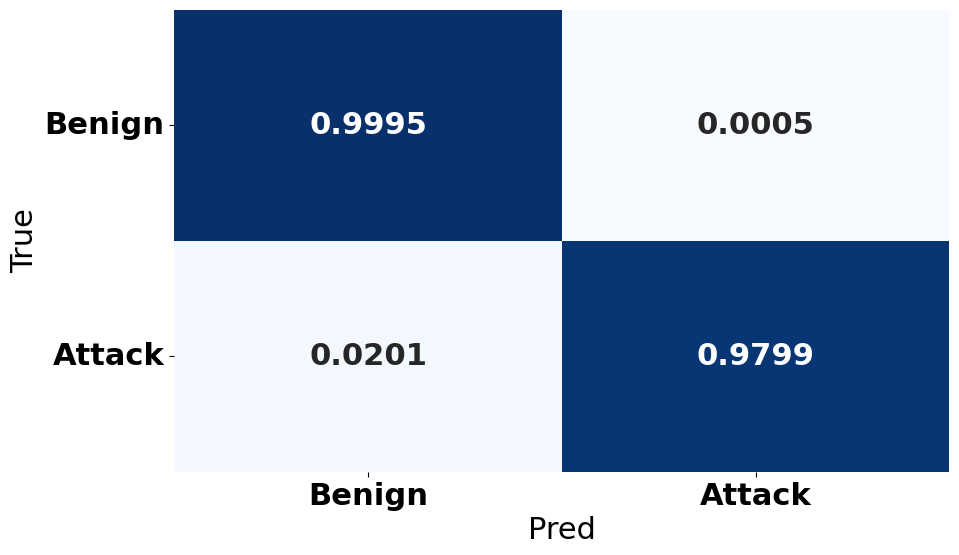

In [ ]:
cm = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, fmt='.4f', xticklabels=unique_classes,
       yticklabels=unique_classes, cmap=plt.cm.Blues,
            cbar=False)
plt.rcParams["figure.figsize"] = (10,6)
plt.yticks(rotation=0)
plt.ylabel('True')
plt.xlabel('Pred')
plt.show(block=False)

In [ ]:
# Calculate multiclass Brier score
y_prob_rf = rf_clf.predict_proba(X_test)[:,1]
# Calculate Brier score for binary classification
brier_score_pos = metrics.brier_score_loss(y_test, y_prob_rf)
print(f'Brier score (binary): {brier_score_pos:.4f}')

Brier score (binary): 0.0082


In [ ]:
# plt.rcParams.update({'font.size': 12,'font.weight':'bold'})

In [ ]:
tp_instances = np.where((y_test == 1) & (xgb_predicted_values == 1))[0]
tn_instances = np.where((y_test == 0) & (xgb_predicted_values == 0))[0]
fp_instances = np.where((y_test == 0) & (xgb_predicted_values == 1))[0]
fn_instances = np.where((y_test == 1) & (xgb_predicted_values == 0))[0]

In [ ]:
print(len(tp_instances), len(tn_instances), len(fp_instances),len(fn_instances))

218626 219483 265 1122


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.70])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.30])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.70])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.30])*100/len(fn_instances))

99.93596370056626
99.74348810614033
36.9811320754717
84.58110516934046


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.75])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.25])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.75])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.25])*100/len(fn_instances))

99.91721021287495
99.59769093733911
25.660377358490567
79.76827094474153


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.80])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.20])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.80])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.20])*100/len(fn_instances))

99.89708451876722
99.38491819411982
19.245283018867923
74.59893048128342


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.85])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.15])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.85])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.15])*100/len(fn_instances))

99.87558661824303
99.04047238282692
12.830188679245284
67.55793226381462


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.9])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.1])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.9])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.1])*100/len(fn_instances))

99.84814248991428
98.27640409507798
9.056603773584905
58.37789661319073


In [ ]:
print(len([x for x in y_prob[tp_instances] if x>=0.95])*100/len(tp_instances))
print(len([x for x in y_prob[tn_instances] if x<=0.05])*100/len(tn_instances))
print(len([x for x in y_prob[fp_instances] if x>=0.95])*100/len(fp_instances))
print(len([x for x in y_prob[fn_instances] if x<=0.05])*100/len(fn_instances))

99.81520953591979
95.88669737519534
5.283018867924528
40.819964349376114


In [ ]:
def plot_overlapping_shap(shap_values_instance1, shap_values_instance2, feature_names, feature_values, label_exp, raw_prediction_prob=None, pred_val=None, color_instance1=None, color_instance2=None, bar_width1=0.75, bar_width2=0.9):
    """
    Plot two overlapping SHAP bar plots for two instances.

    Parameters:
    - shap_values_instance1: 1D array-like, SHAP values for the first instance.
    - shap_values_instance2: 1D array-like, SHAP values for the second instance.
    - feature_names: list of feature names.
    - feature_values: list of feature values.
    - label_exp: label for the second instance.
    - raw_prediction_prob: Probability of the prediction to be displayed as text.
    - pred_val: Prediction value to be displayed as text.
    - color_instance1: tuple or list of colors for the first instance, default to bright colors.
    - color_instance2: tuple or list of colors for the second instance, default to transparent colors.
    - bar_width1: width of the bars for the first instance.
    - bar_width2: width of the bars for the second instance.
    """

    light_red, light_green = (1.0, 0.71, 0.71, 0.5), (0.56, 0.93, 0.56, 0.5)  # Light orange

    # Default colors
    if color_instance1 is None:
        color_instance1 = ['deepskyblue' if v < 0 else 'deeppink' for v in shap_values_instance1]
    if color_instance2 is None:
        color_instance2 = [light_green if v < 0 else light_red for v in shap_values_instance2]

    # Convert inputs to numpy arrays
    shap_values_instance1 = np.array(shap_values_instance1)
    shap_values_instance2 = np.array(shap_values_instance2)

    # Ensure the inputs are of the same length
    assert len(shap_values_instance1) == len(shap_values_instance2) == len(feature_names) == len(feature_values), \
        "All inputs must have the same length"

    # Create y-tick labels with feature values
    feature_labels = [f"{name} = {round(value, 4)}" for name, value in zip(feature_names, feature_values)]

    # Plotting
    fig, ax = plt.subplots()

    # Bar plot for the first instance
    bar1 = ax.barh(np.arange(len(feature_names)), shap_values_instance1, height=bar_width1, color=color_instance1, label='Instance 1')

    # Bar plot for the second instance with different width and transparency
    bar2 = ax.barh(np.arange(len(feature_names)), shap_values_instance2, height=bar_width2, color=color_instance2, label=label_exp)

    # Adding feature names with values as y-axis labels
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_yticklabels(feature_labels)

    # Adding labels and title
    ax.set_xlabel('SHAP value')

    # Add text for raw_prediction_prob and pred_val if provided
    title_text = ""
    if pred_val is not None:
        if int(pred_val) == 0:
            if raw_prediction_prob is not None:
                title_text += f"Raw Prediction Probability: {1-raw_prediction_prob:.3f}\n"
                title_text += f"Prediction Value: {pred_val:.0f}"
        else:
            if raw_prediction_prob is not None:
                title_text += f"Raw Prediction Probability: {raw_prediction_prob:.3f}\n"
                title_text += f"Prediction Value: {pred_val:.0f}"
    plt.title(title_text.strip())

    # Custom legend
    legend_elements = [
        Patch(facecolor='deeppink', edgecolor='deeppink', label='Instance 1 (positive)'),
        Patch(facecolor='deepskyblue', edgecolor='deepskyblue', label='Instance 1 (negative)'),
        Patch(facecolor=light_red, edgecolor=light_red, label=f'{label_exp} (positive)'),
        Patch(facecolor=light_green, edgecolor=light_green, label=f'{label_exp} (negative)')
    ]
    ax.legend(handles=legend_elements)

    # plt.show()


In [ ]:
def top_20_features(shap_value_group):
    abs_shap_values = np.abs(shap_value_group)
    top_20_indices = np.argsort(abs_shap_values)[-20:]

    # Sort these indices based on the original absolute values in ascending order
    sorted_top_20_indices = top_20_indices[np.argsort(abs_shap_values[top_20_indices])]

    return sorted_top_20_indices

In [ ]:
feature_names = train_data.columns

In [ ]:
tp_tn_random_size = 100000
fp_fn_random_size = min(len(fp_instances), min(fn_instances))

random_tp_instances = X_test[np.random.choice(tp_instances, size=tp_tn_random_size, replace=False)]
random_tn_instances = X_test[np.random.choice(tn_instances, size=tp_tn_random_size, replace=False)]
random_fp_instances = X_test[np.random.choice(fp_instances, size=len(fp_instances), replace=False)]
random_fn_instances = X_test[np.random.choice(fn_instances, size=len(fn_instances), replace=False)]

[14:21:43] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 99972/100000 [04:09<00:00]        

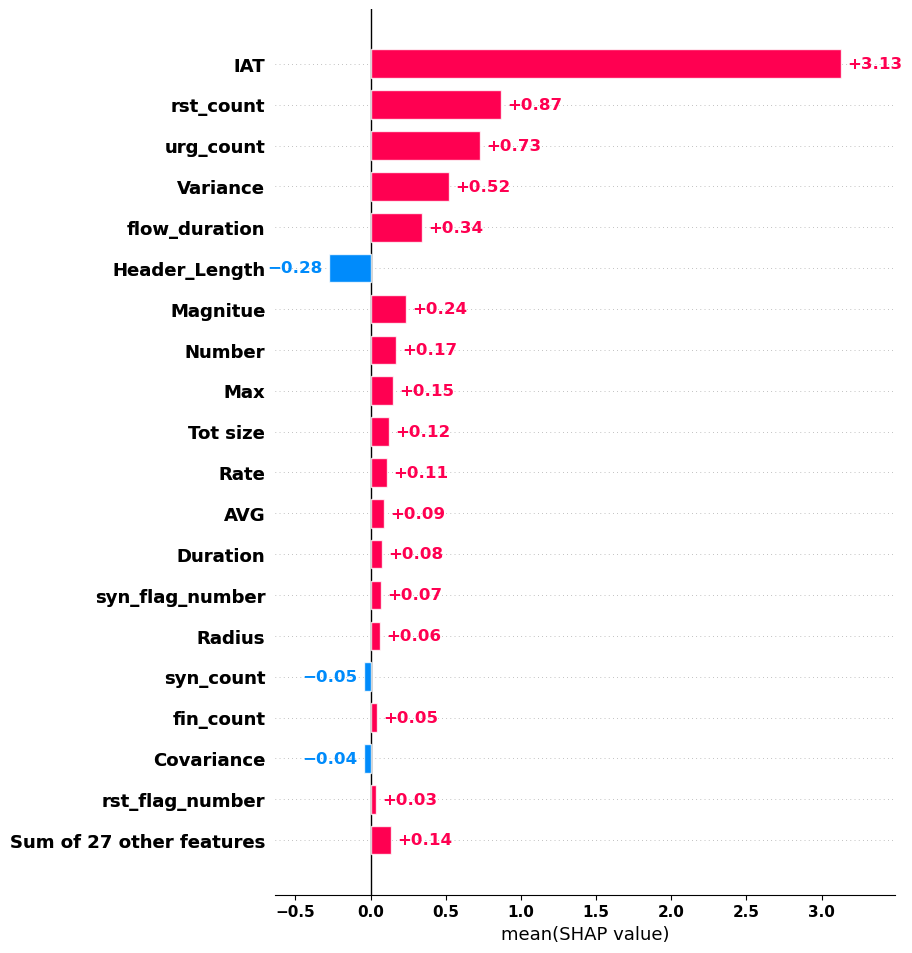

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


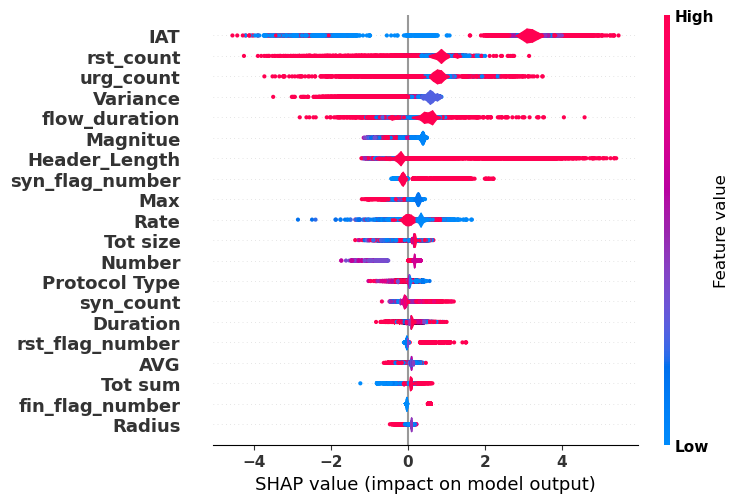

In [ ]:
explainer = shap.TreeExplainer(xgb_classifier, X_train)
tp_shap_values = explainer(random_tp_instances,check_additivity=False)
tp_shap_values.feature_names = feature_names
shap.plots.bar(tp_shap_values.mean(0),max_display=20)
shap.summary_plot(tp_shap_values, plot_type="violin", class_names=unique_classes, plot_size=0.2,max_display=20)

In [ ]:
tp_shap_values_mean = tp_shap_values.values.mean(0)
tp_top_20_features = top_20_features(tp_shap_values_mean)
tp_top_20_features

array([19,  9, 43, 16, 15, 42,  8,  3, 36,  4, 38, 35, 40, 41,  1,  0, 44,
       17, 18, 39], dtype=int64)

282600


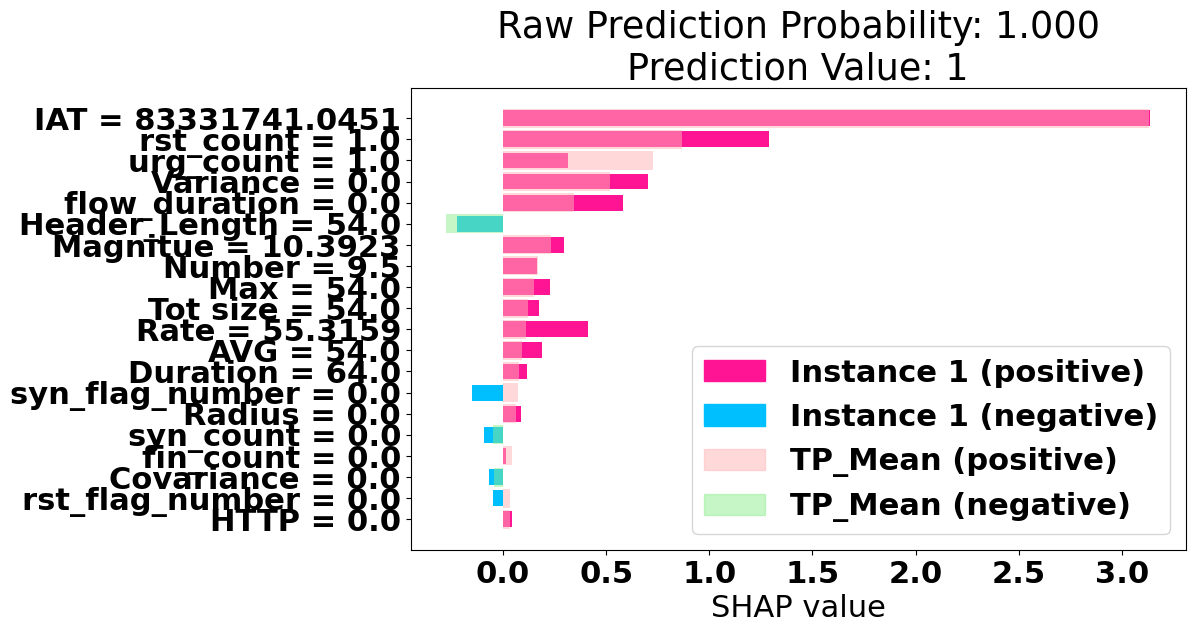

In [ ]:
# tp_random_case = tp_shap_values[random.randrange(tp_tn_random_size-1)]
rand_idx = random.choice(tp_instances)
print(rand_idx)
tp_random_case = explainer(X_test[rand_idx])
# top_20_indices = lambda array: np.argsort(np.abs(array))[-20:]
# tp_top_20_features = top_20_indices(tp_random_case.values)
# print(tp_random_case[tp_top_20_features].values)
# print(tp_random_case.values[tp_top_20_features])
plot_overlapping_shap(tp_random_case.values[tp_top_20_features], tp_shap_values_mean[tp_top_20_features], feature_names[tp_top_20_features], tp_random_case.data[tp_top_20_features], 'TP_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
plt.rcParams["figure.figsize"] = (6,7)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
plt.show()

100%|===================| 99813/100000 [06:38<00:00]        

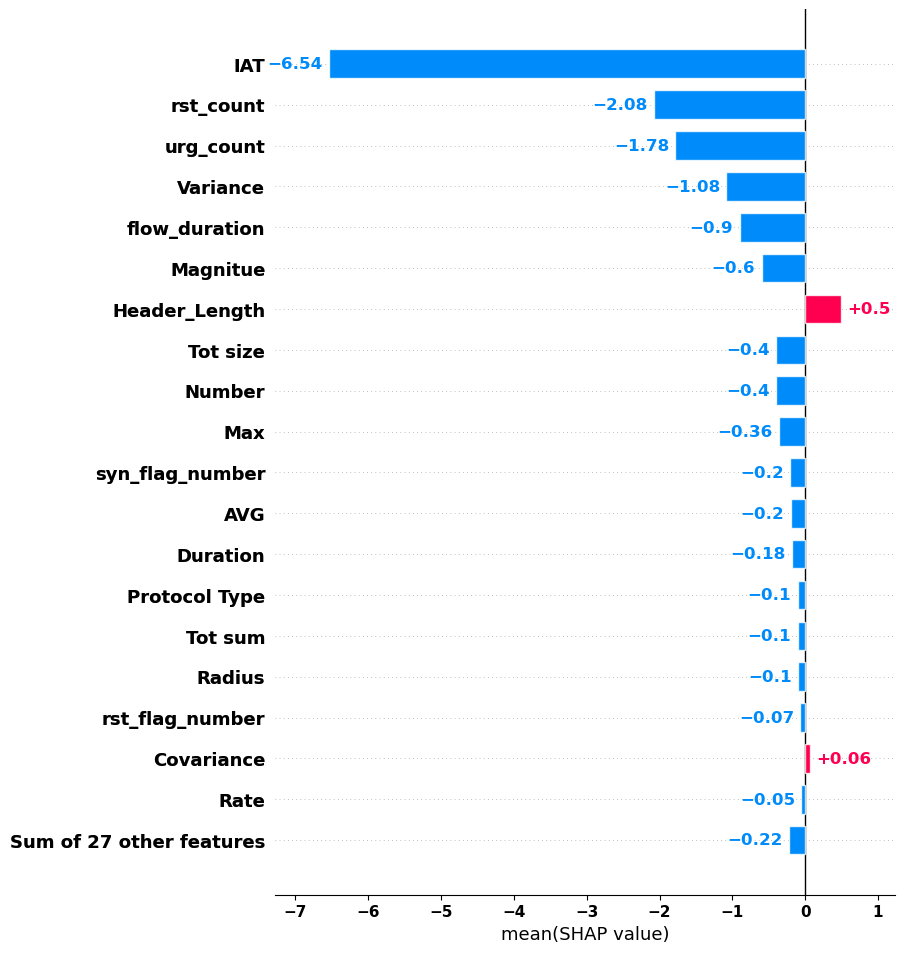

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


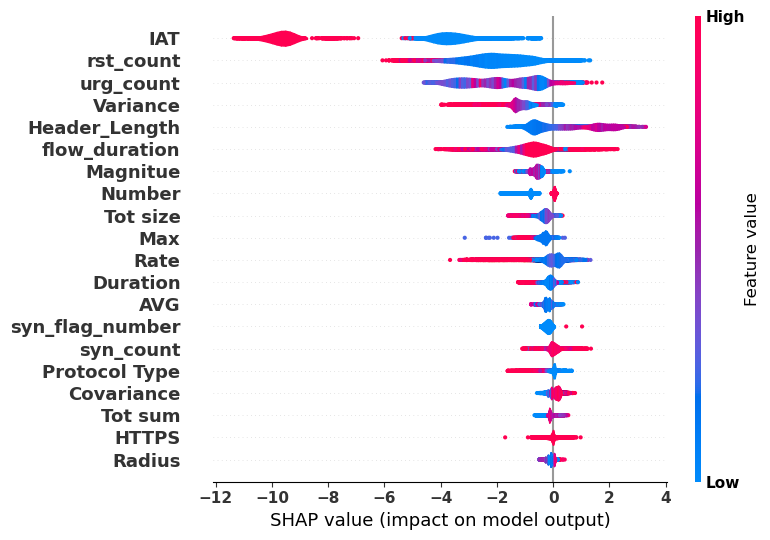

In [ ]:
tn_shap_values = explainer(random_tn_instances,check_additivity=False)
tn_shap_values.feature_names = feature_names
shap.plots.bar(tn_shap_values.mean(0),max_display=20)
shap.summary_plot(tn_shap_values, plot_type="violin", class_names=unique_classes, plot_size=0.2,max_display=20)

In [ ]:
tn_shap_values_mean = tn_shap_values.values.mean(0)
tn_top_20_features = top_20_features(tn_shap_values_mean)
tn_top_20_features

array([19,  4, 43,  9, 42, 33,  2,  3, 36,  8, 35, 40, 38,  1, 41,  0, 44,
       17, 18, 39], dtype=int64)

180819


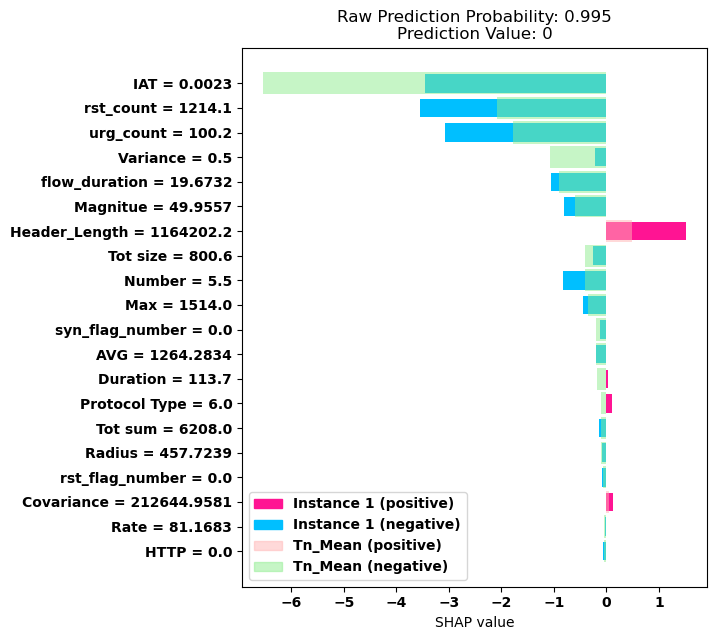

In [ ]:
# tn_random_case = tn_shap_values[random.randrange(tp_tn_random_size-1)]
rand_idx = random.choice(tn_instances)
print(rand_idx)
tn_random_case = explainer(X_test[rand_idx])
# top_20_indices = lambda array: np.argsort(np.abs(array))[-20:]
# tn_top_20_features = top_20_indices(tn_random_case.values)
# print(tn_random_case[tn_top_20_features].values)
# print(tn_random_case.values[tn_top_20_features])
plot_overlapping_shap(tn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'Tn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
plt.rcParams["figure.figsize"] = (6,7)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
plt.show()

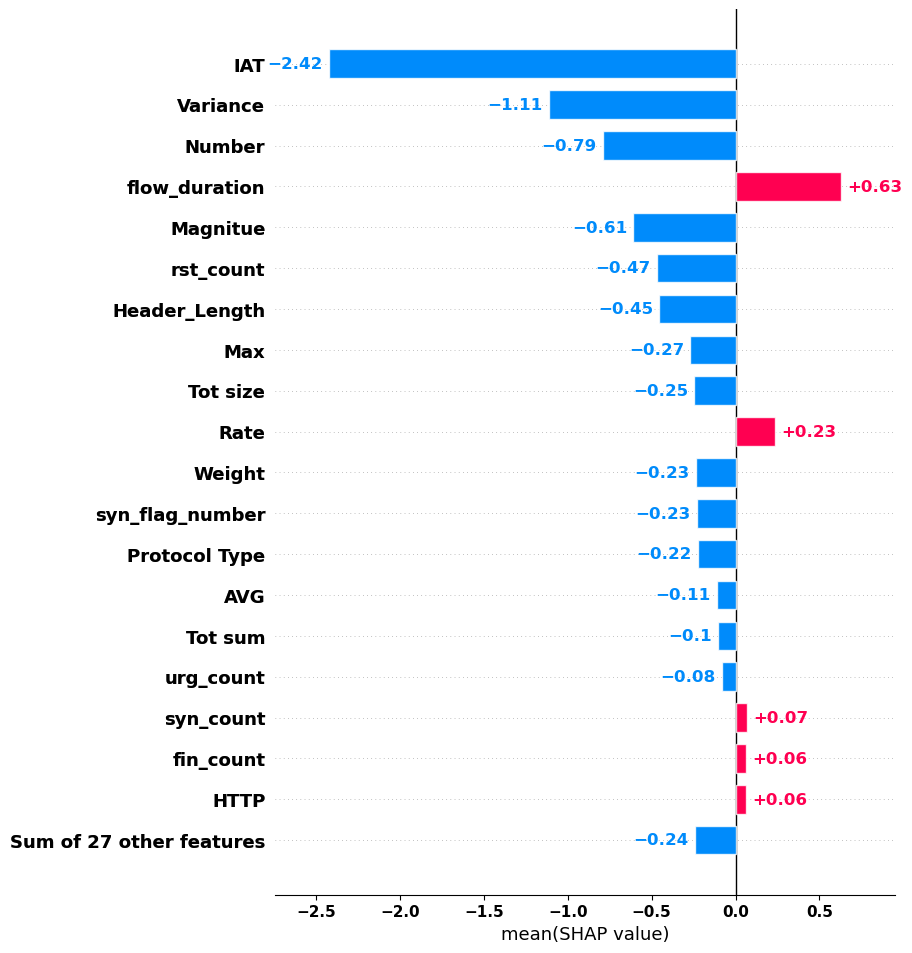

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


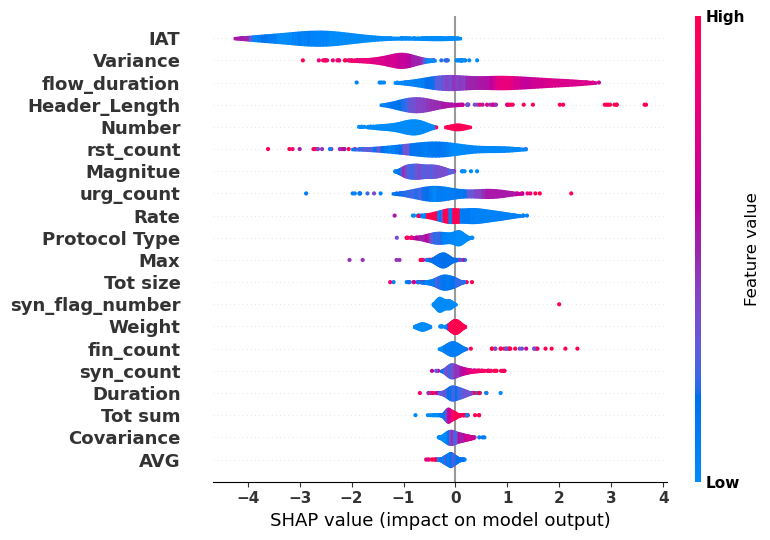

In [ ]:
fp_shap_values = explainer(random_fp_instances,check_additivity=False)
fp_shap_values.feature_names = feature_names
shap.plots.bar(fp_shap_values.mean(0),max_display=20)
shap.summary_plot(fp_shap_values, plot_type="violin", class_names=unique_classes, plot_size=0.2,max_display=20)

In [ ]:
fp_shap_values_mean = fp_shap_values.values.mean(0)
fp_top_20_features = top_20_features(fp_shap_values_mean)
fp_top_20_features

array([37, 19, 16, 15, 17, 33, 36,  2,  8, 45,  4, 38, 35,  1, 18, 41,  0,
       40, 44, 39], dtype=int64)

21776


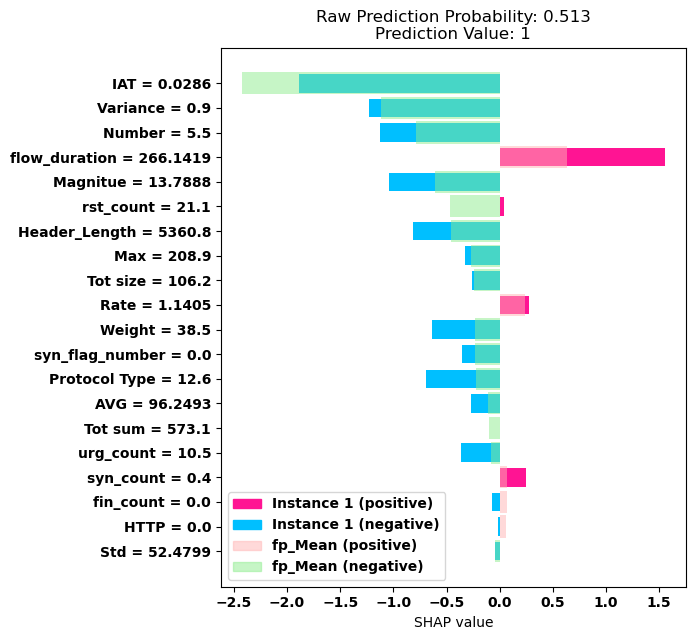

In [ ]:
# fp_random_case = fp_shap_values[random.randrange(fp_fn_random_size-1)]
rand_idx = random.choice(fp_instances)
print(rand_idx)
fp_random_case = explainer(X_test[rand_idx])
# top_20_indices = lambda array: np.argsort(np.abs(array))[-20:]
# fp_top_20_features = top_20_indices(fp_random_case.values)
# print(fp_random_case[fp_top_20_features].values)
# print(fp_random_case.values[fp_top_20_features])
plot_overlapping_shap(fp_random_case.values[fp_top_20_features], fp_shap_values_mean[fp_top_20_features], feature_names[fp_top_20_features], fp_random_case.data[fp_top_20_features], 'fp_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
plt.rcParams["figure.figsize"] = (6,7)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
plt.show()

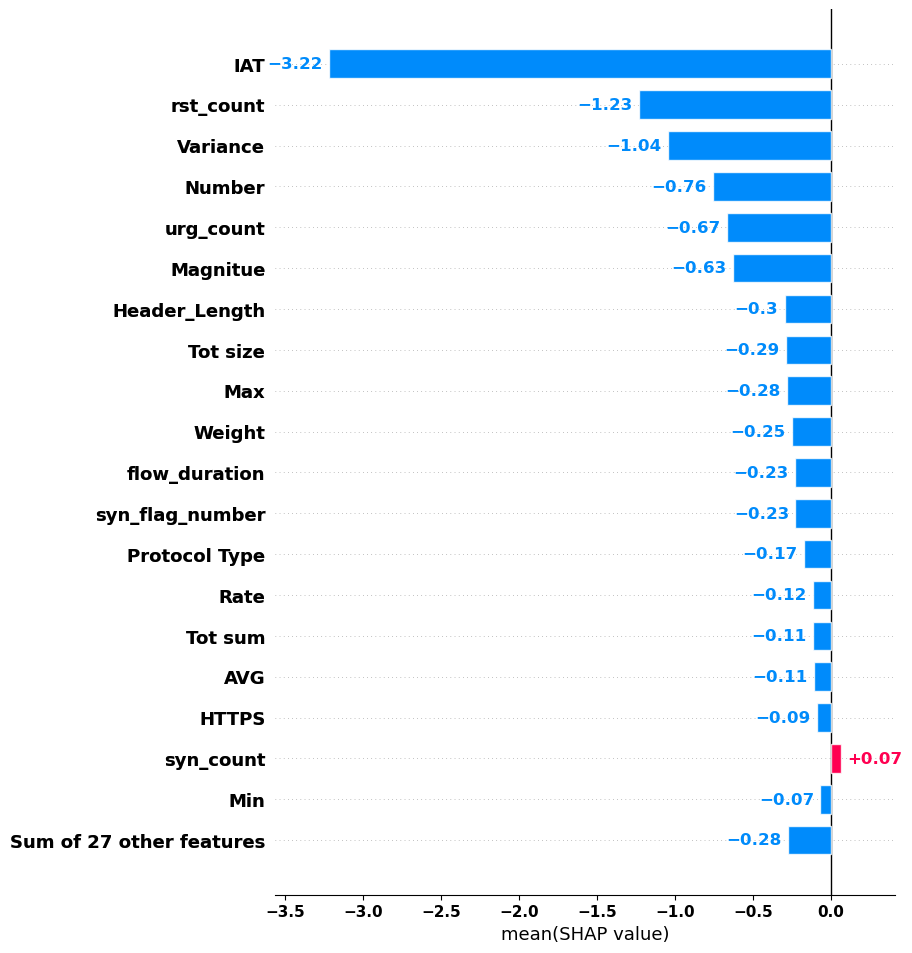

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


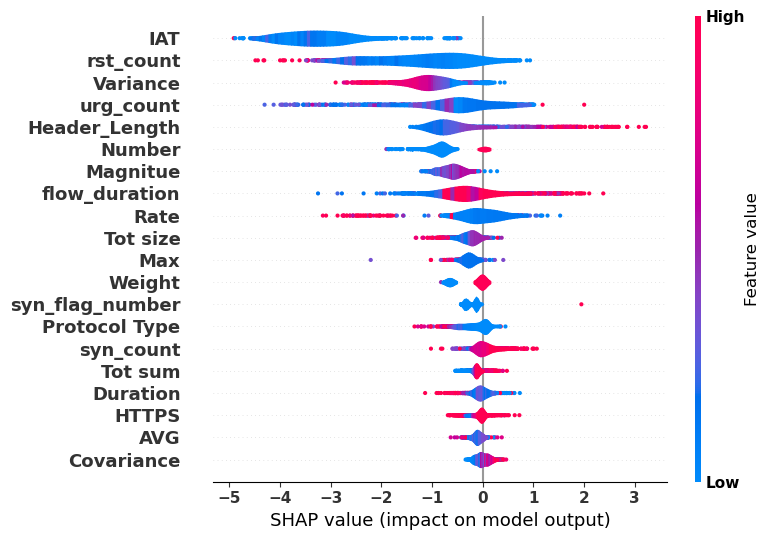

In [ ]:
fn_shap_values = explainer(random_fn_instances,check_additivity=False)
fn_shap_values.feature_names = feature_names
shap.plots.bar(fn_shap_values.mean(0),max_display=20)
shap.summary_plot(fn_shap_values, plot_type="violin", class_names=unique_classes, plot_size=0.2,max_display=20)

In [ ]:
fn_shap_values_mean = fn_shap_values.values.mean(0)
fn_top_20_features = top_20_features(fn_shap_values_mean)
fn_top_20_features

array([19, 34, 15, 20, 36, 33,  4,  2,  8,  0, 45, 35, 38,  1, 41, 17, 40,
       44, 18, 39], dtype=int64)

123505


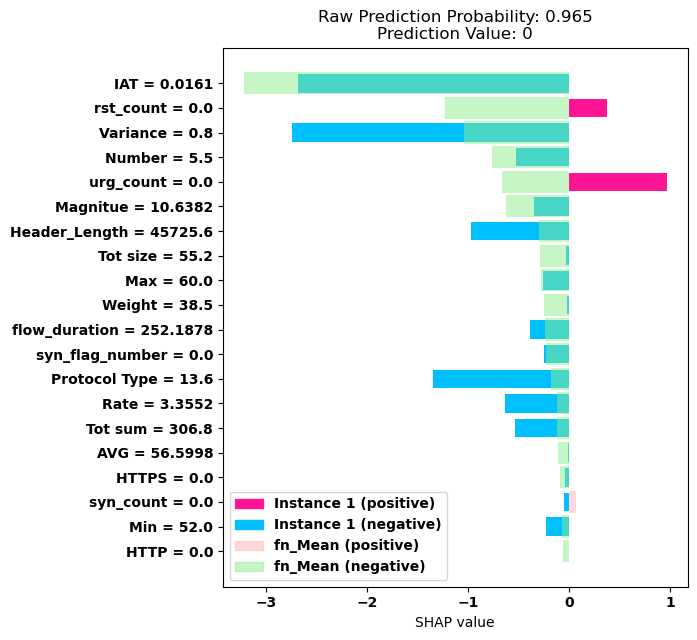

In [ ]:
# fn_random_case = fn_shap_values[random.randrange(fp_fn_random_size-1)]
rand_idx = random.choice(fn_instances)
print(rand_idx)
fn_random_case = explainer(X_test[rand_idx])
# top_20_indices = lambda array: np.argsort(np.abs(array))[-20:]
# fn_top_20_features = top_20_indices(fn_random_case.values)
# print(fn_random_case[fn_top_20_features].values)
# print(fn_random_case.values[fn_top_20_features])
plot_overlapping_shap(fn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'fn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
plt.rcParams["figure.figsize"] = (6,7)
plt.yticks(rotation=0)
plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------


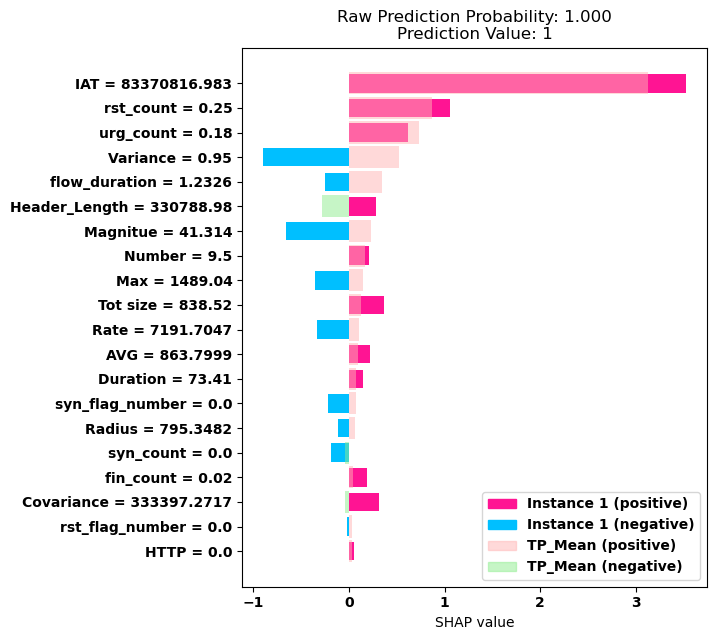

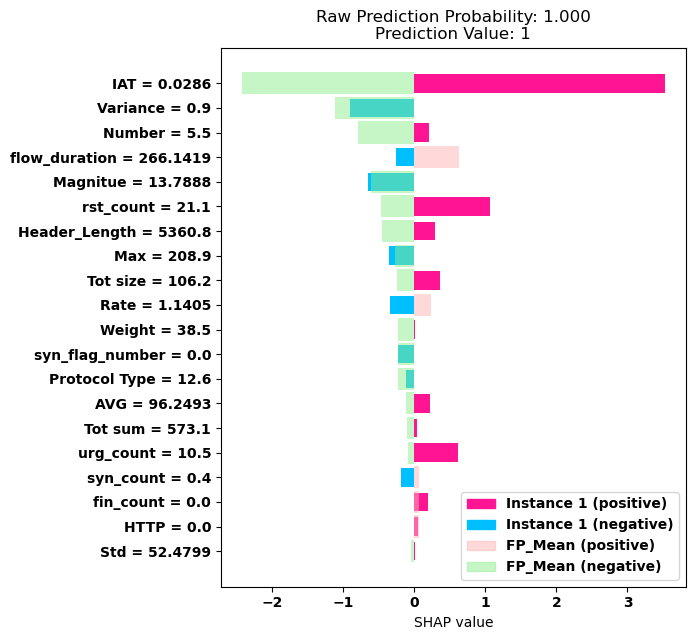

------------------------------------------------------------------------------------------------------------------------------------------------------


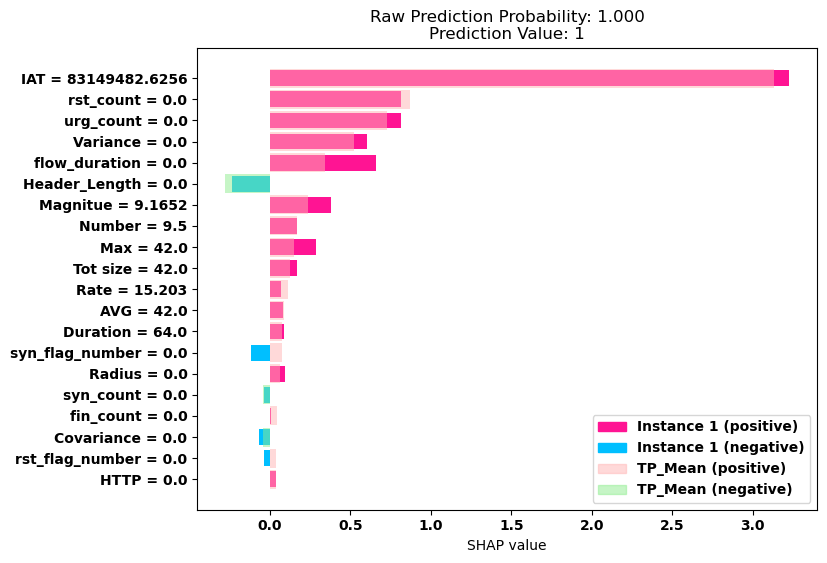

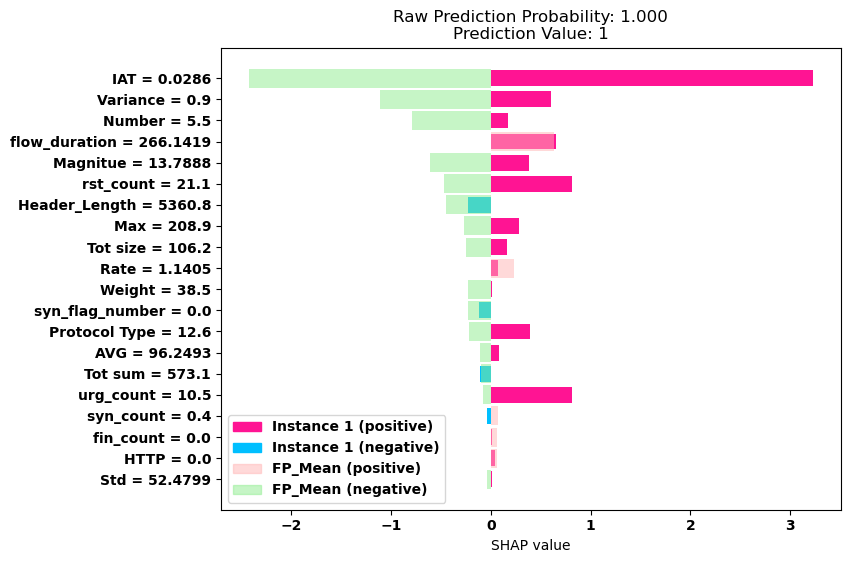

------------------------------------------------------------------------------------------------------------------------------------------------------


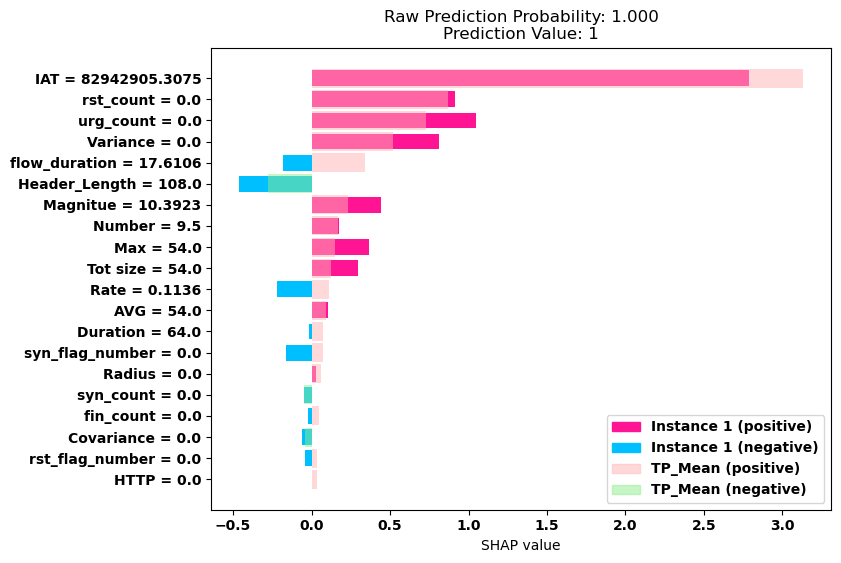

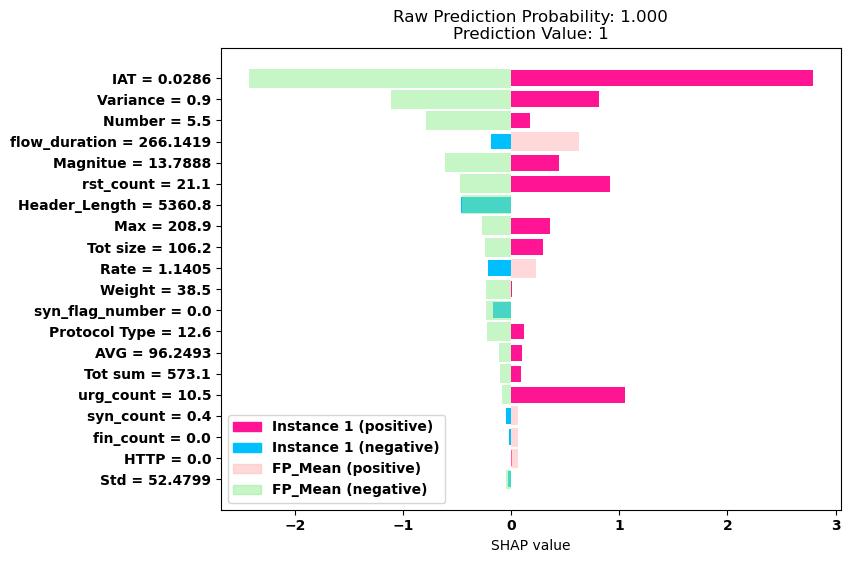

------------------------------------------------------------------------------------------------------------------------------------------------------


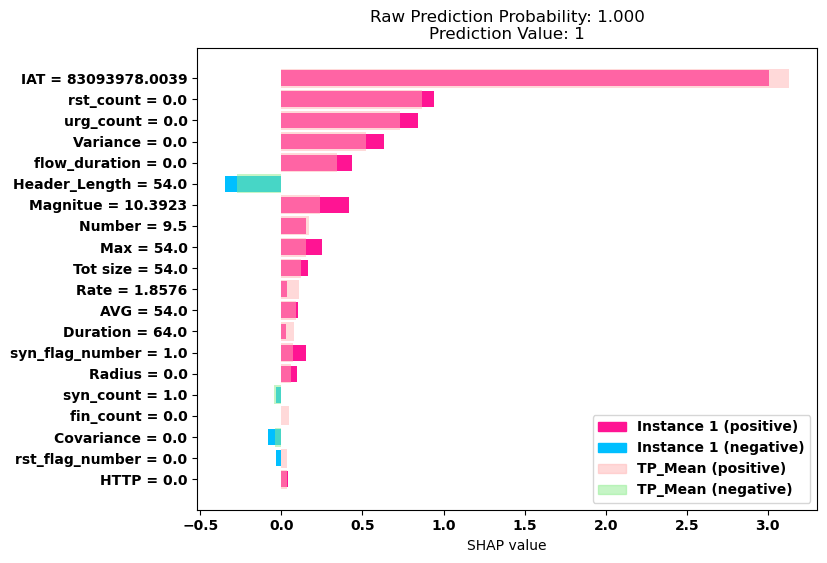

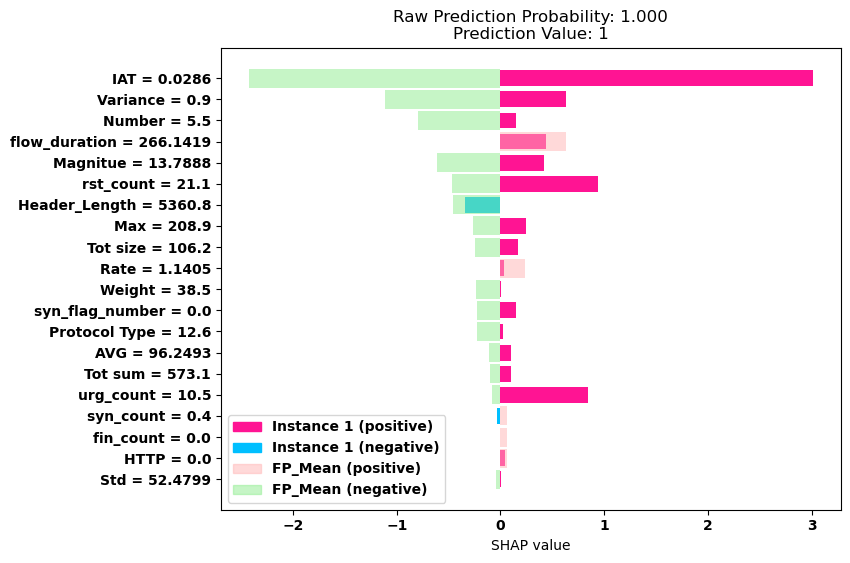

------------------------------------------------------------------------------------------------------------------------------------------------------


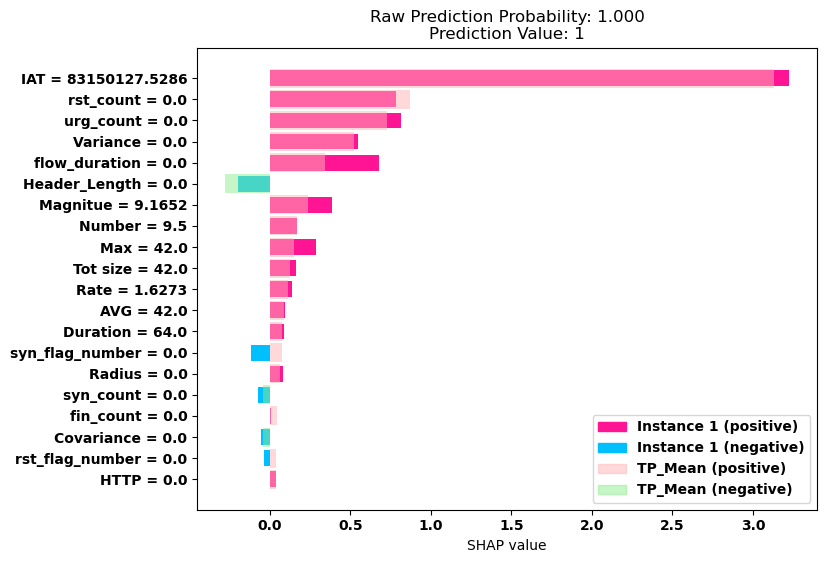

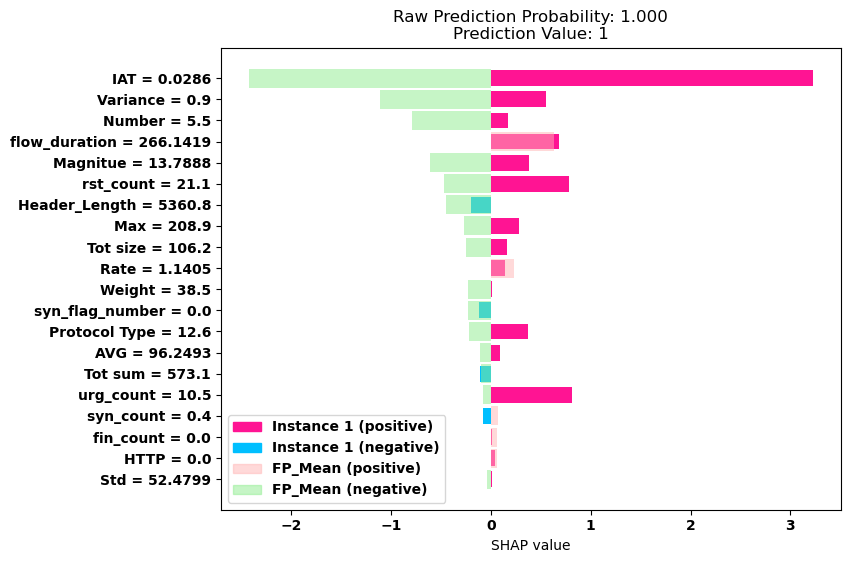

------------------------------------------------------------------------------------------------------------------------------------------------------


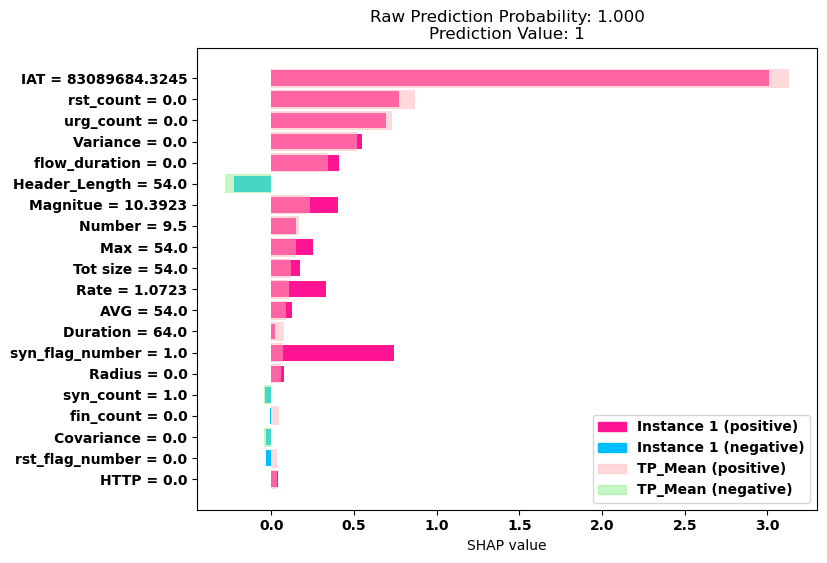

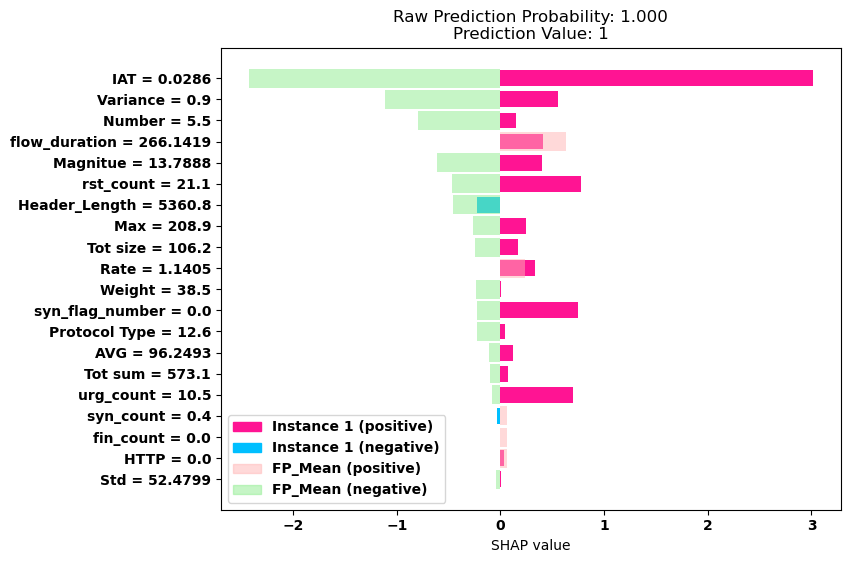

------------------------------------------------------------------------------------------------------------------------------------------------------


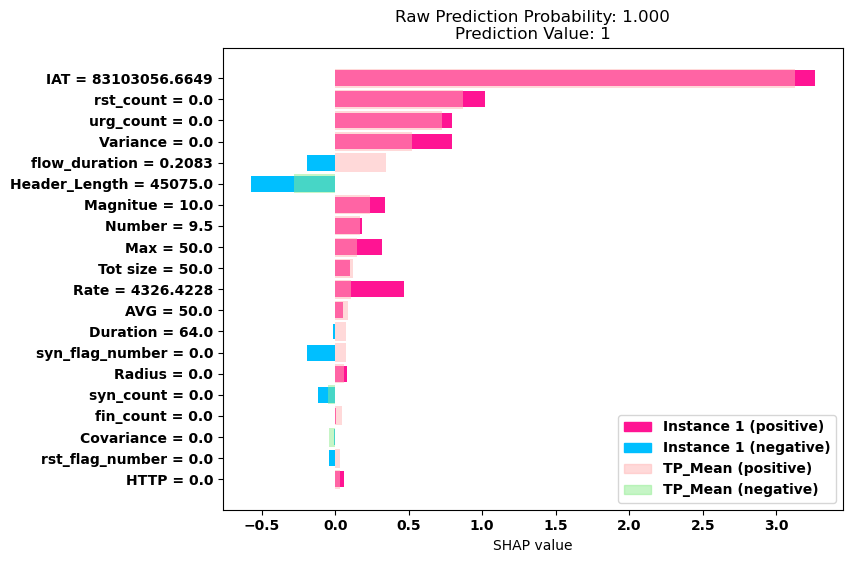

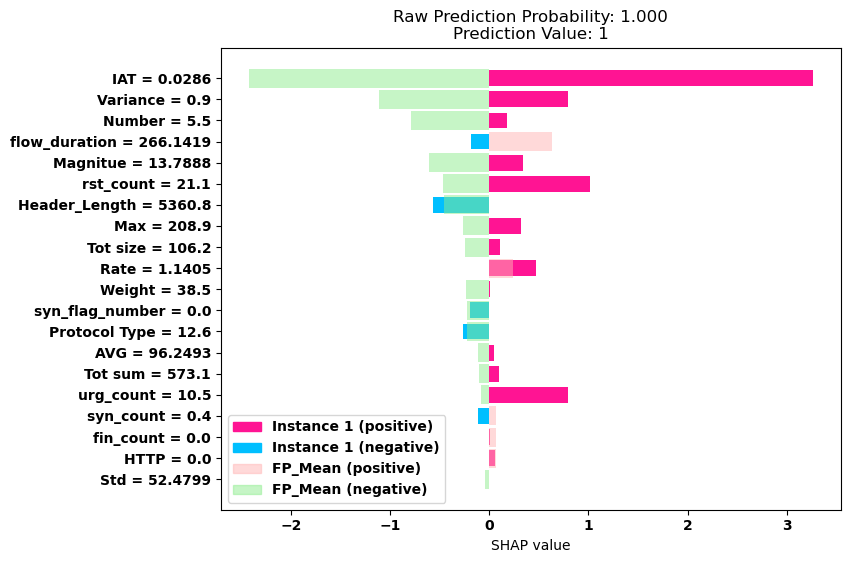

------------------------------------------------------------------------------------------------------------------------------------------------------


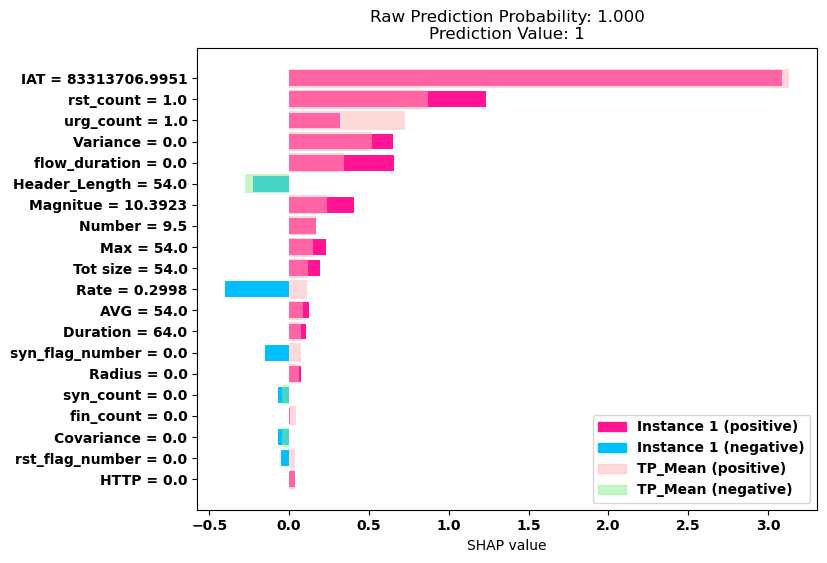

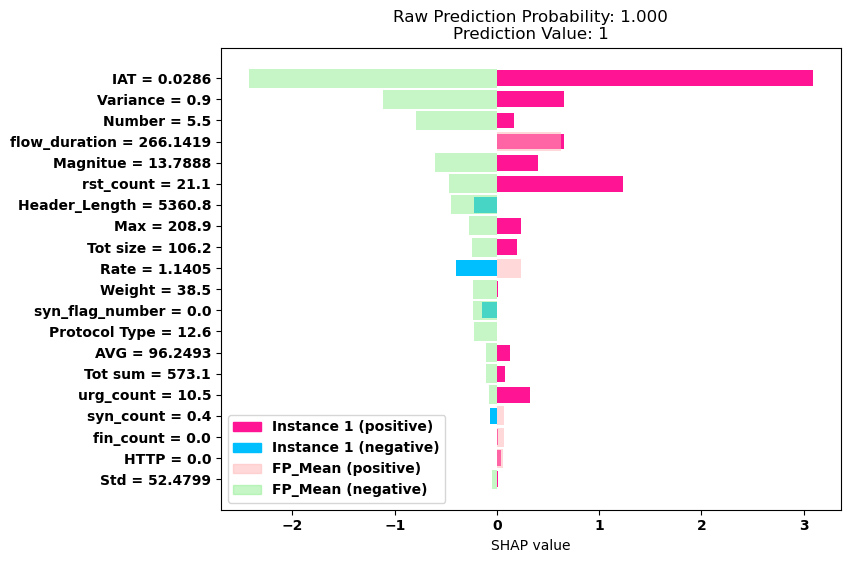

------------------------------------------------------------------------------------------------------------------------------------------------------


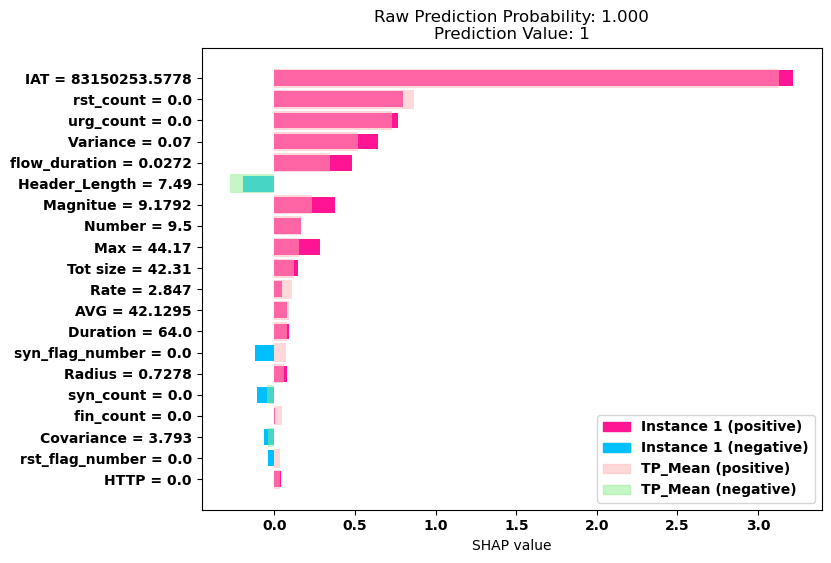

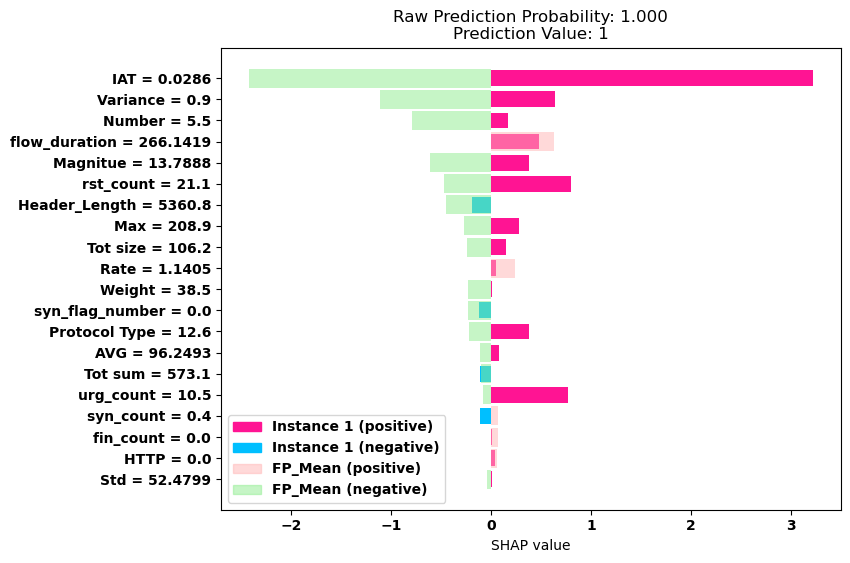

------------------------------------------------------------------------------------------------------------------------------------------------------


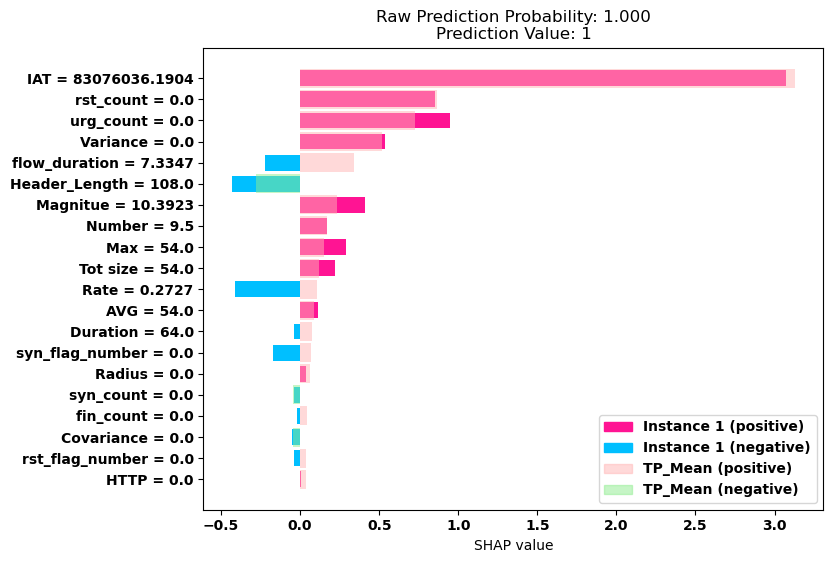

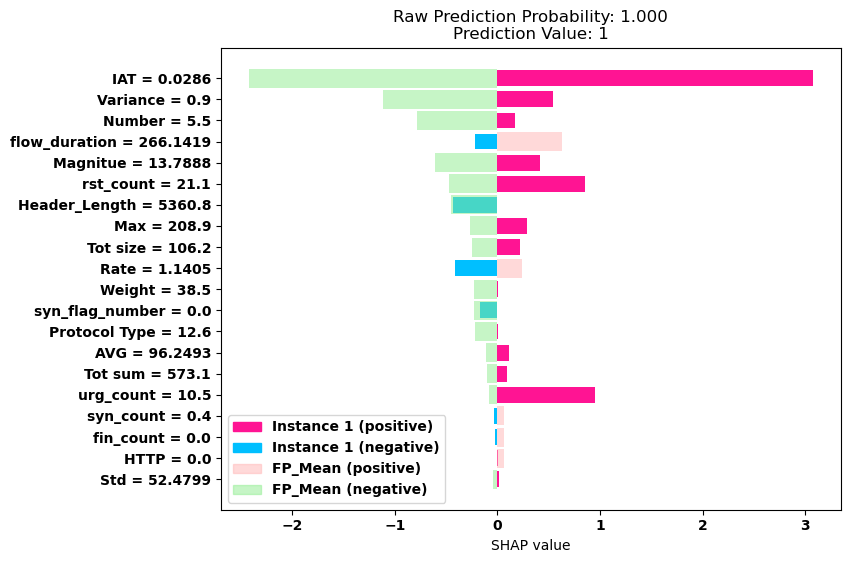

In [ ]:
for i in range(10):
    print('-'*150)
    rand_idx = random.choice(tp_instances)
    tp_random_case = explainer(X_test[rand_idx])
    # print(np.abs(tp_random_case.values))
    plot_overlapping_shap(tp_random_case.values[tp_top_20_features], tp_shap_values_mean[tp_top_20_features], feature_names[tp_top_20_features], tp_random_case.data[tp_top_20_features], 'TP_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(tp_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'TN_Mean')
    plot_overlapping_shap(tp_random_case.values[fp_top_20_features], fp_shap_values_mean[fp_top_20_features], feature_names[fp_top_20_features], fp_random_case.data[fp_top_20_features], 'FP_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(tp_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'FN_Mean')
    plt.rcParams["figure.figsize"] = (8,6)
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
    plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------


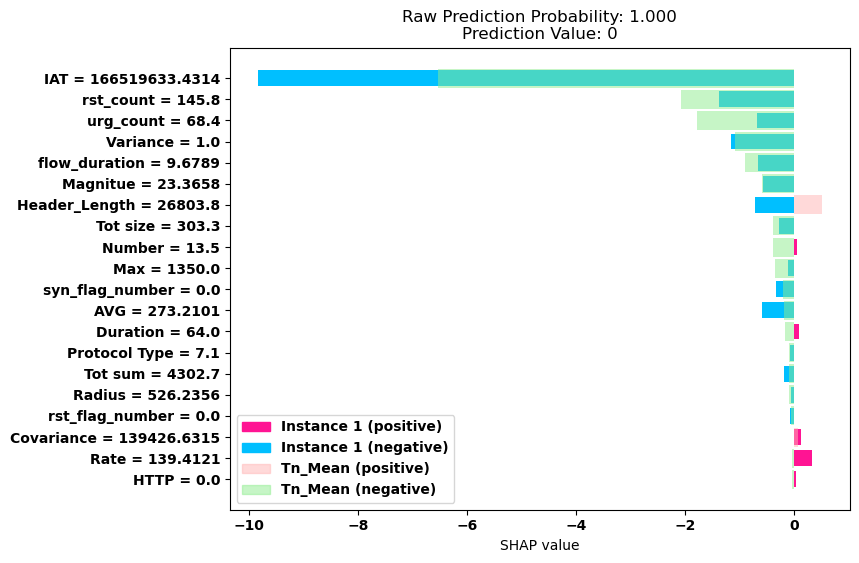

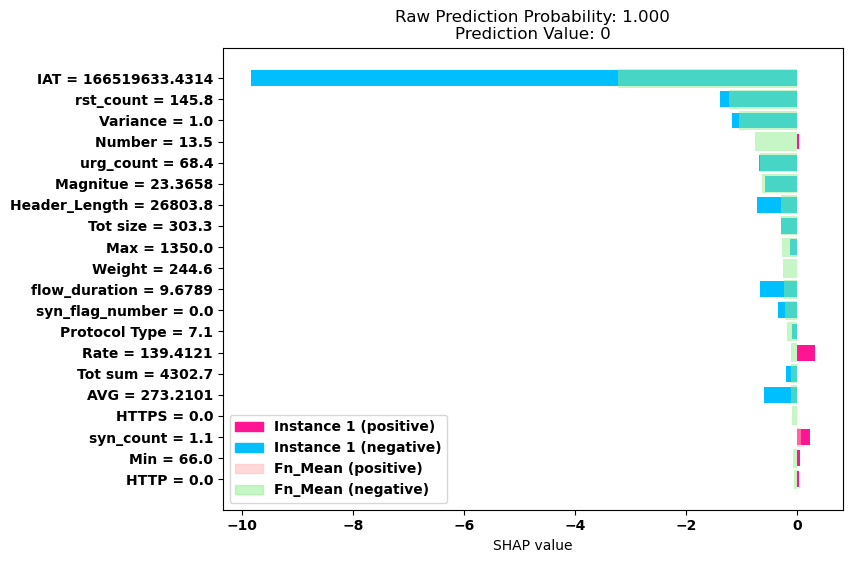

------------------------------------------------------------------------------------------------------------------------------------------------------


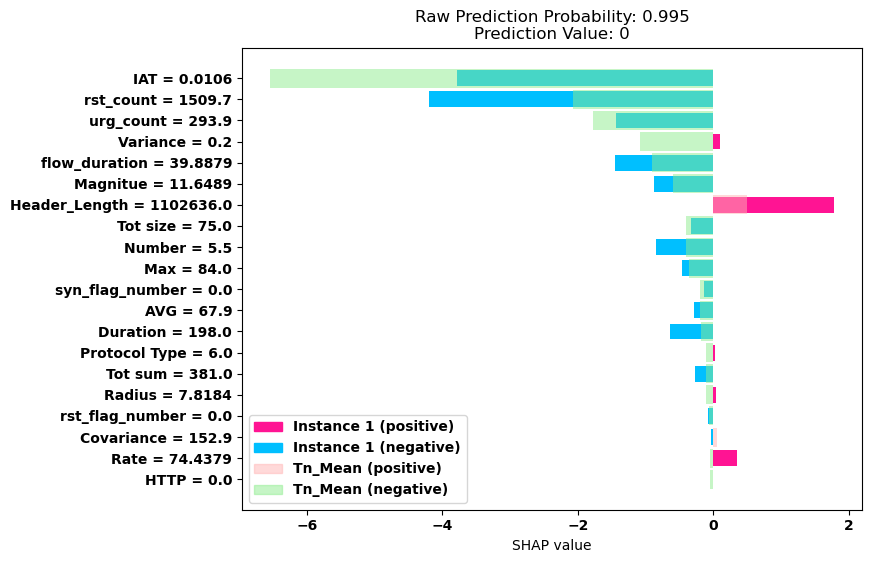

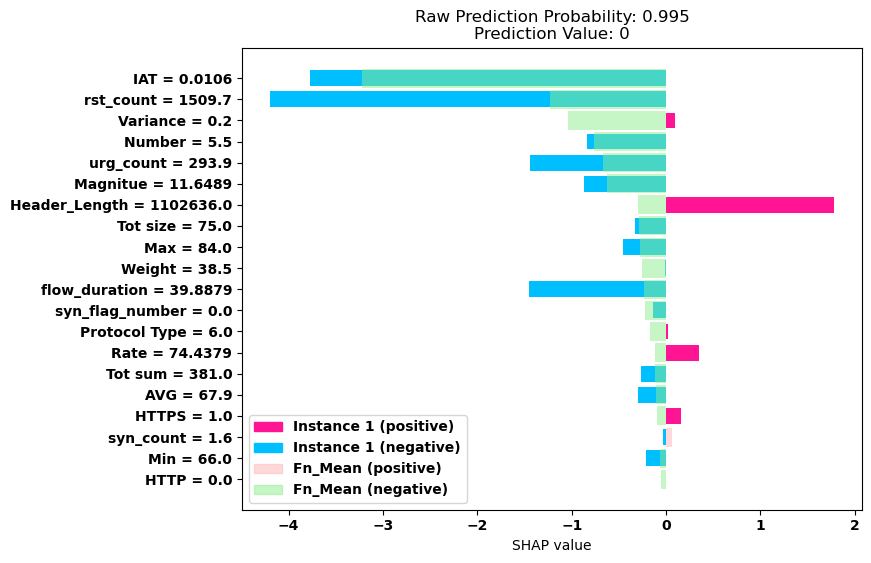

------------------------------------------------------------------------------------------------------------------------------------------------------


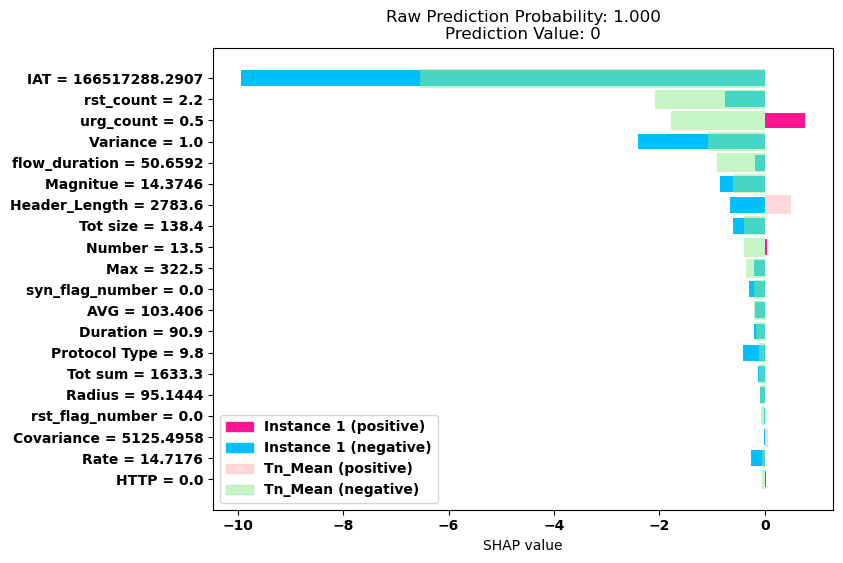

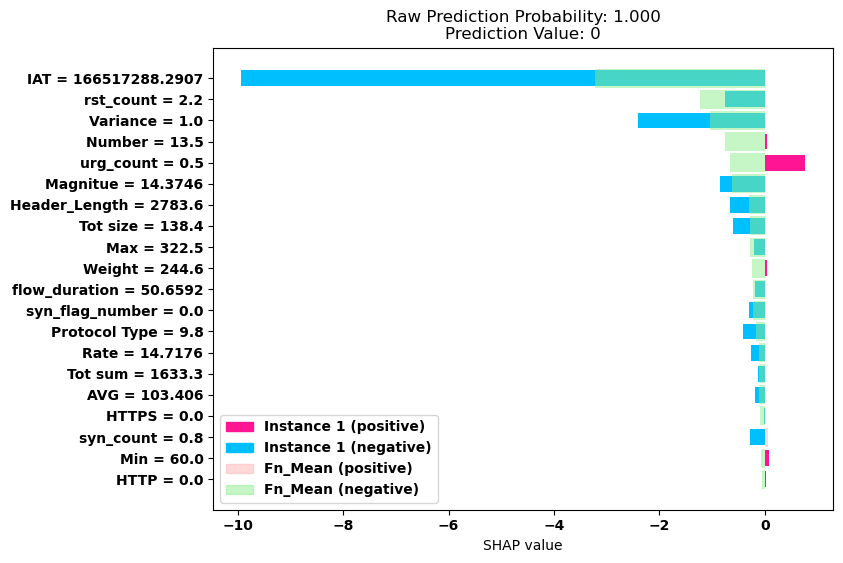

------------------------------------------------------------------------------------------------------------------------------------------------------


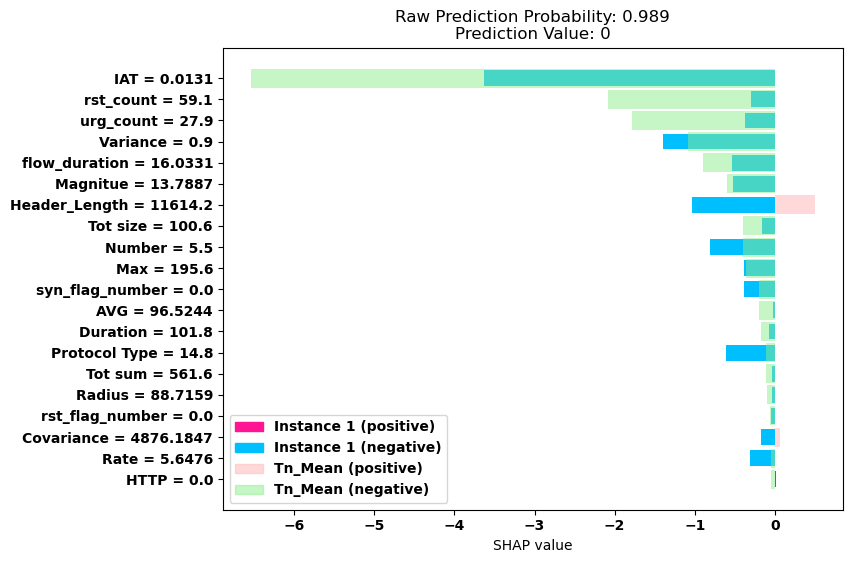

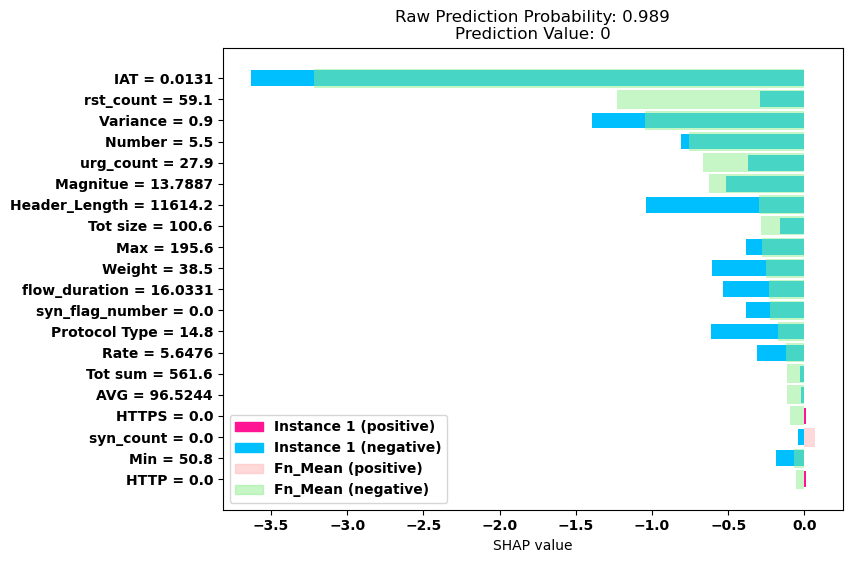

------------------------------------------------------------------------------------------------------------------------------------------------------


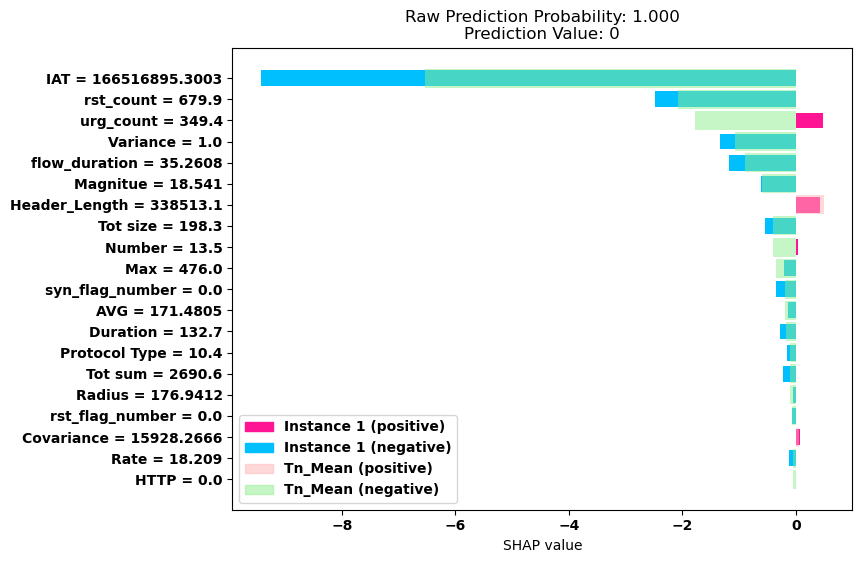

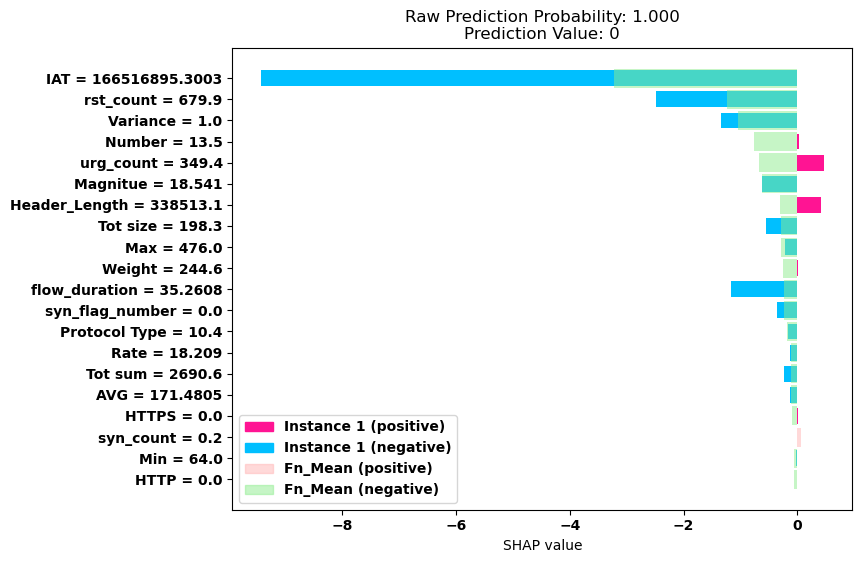

------------------------------------------------------------------------------------------------------------------------------------------------------


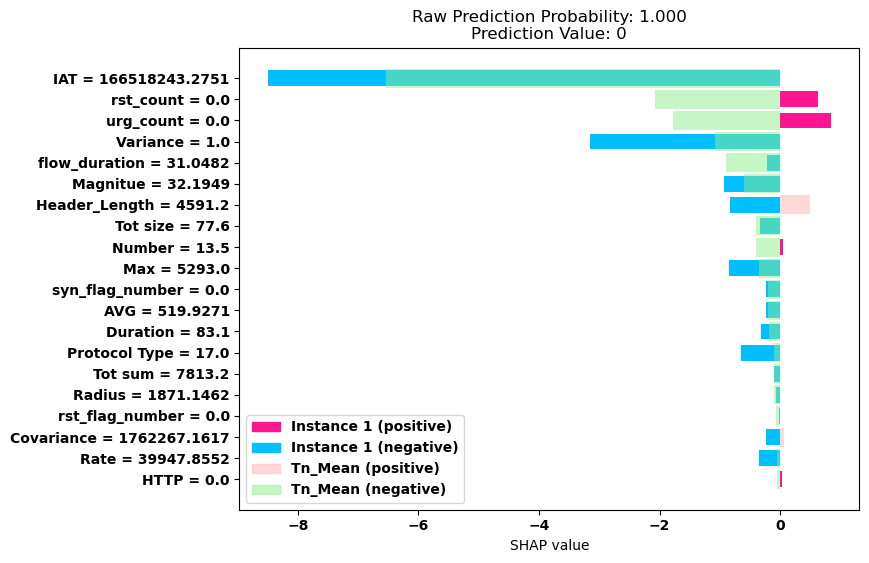

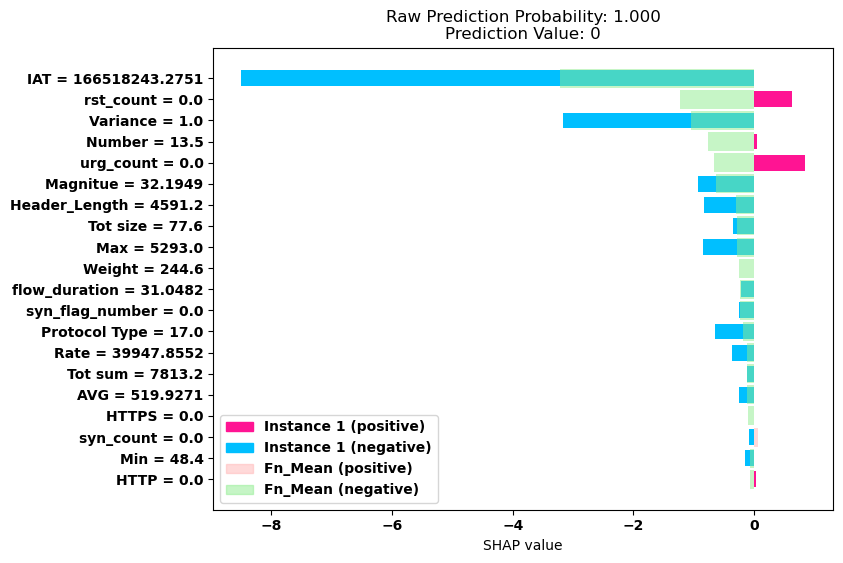

------------------------------------------------------------------------------------------------------------------------------------------------------


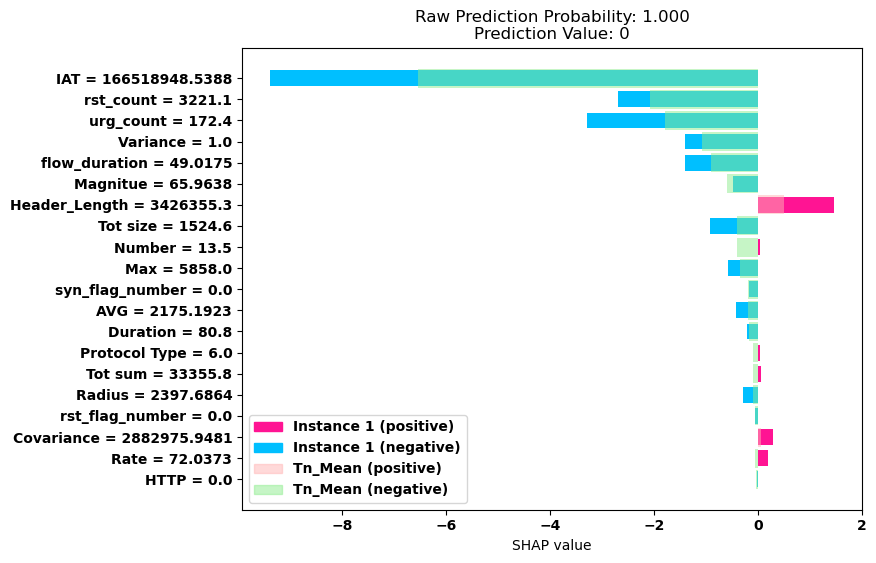

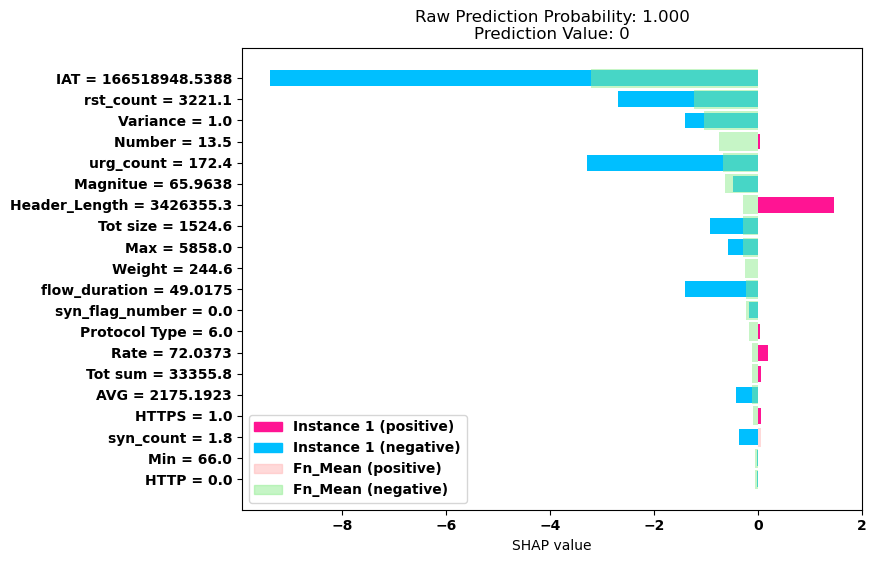

------------------------------------------------------------------------------------------------------------------------------------------------------


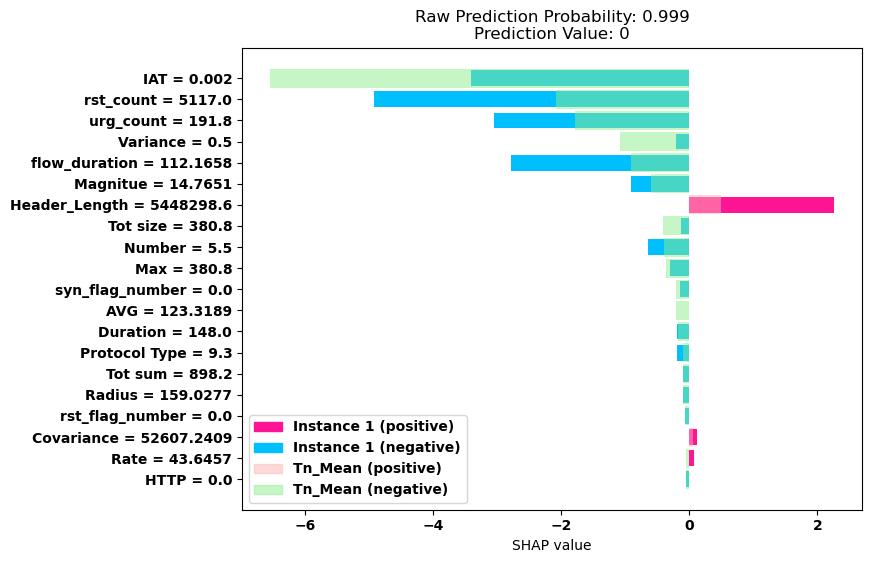

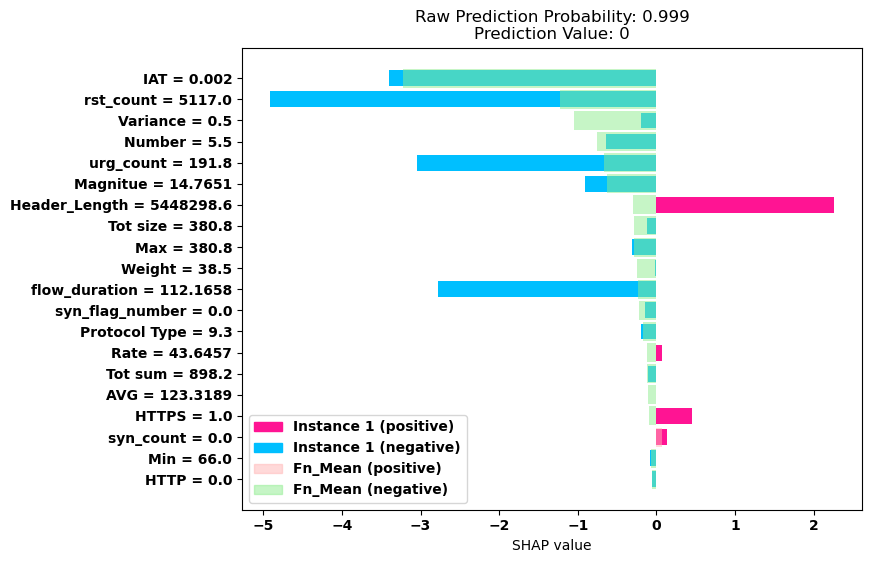

------------------------------------------------------------------------------------------------------------------------------------------------------


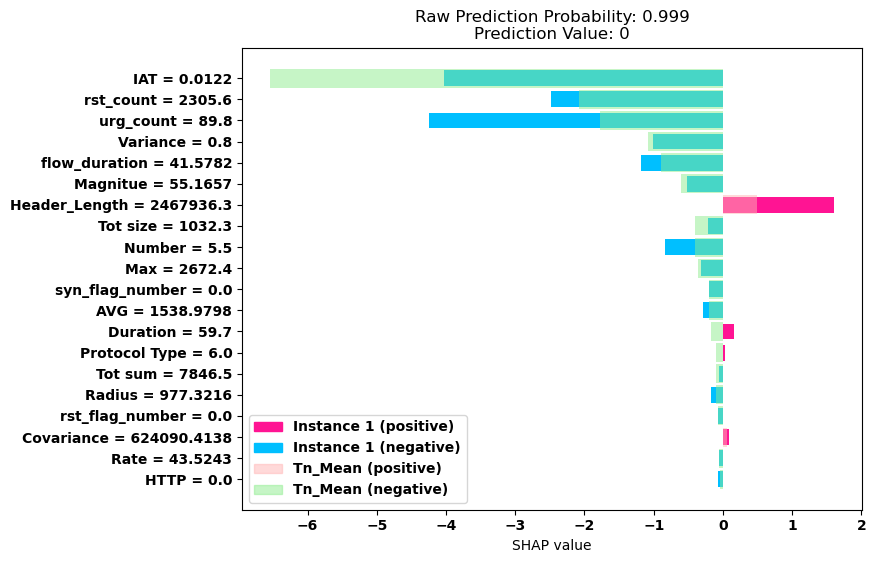

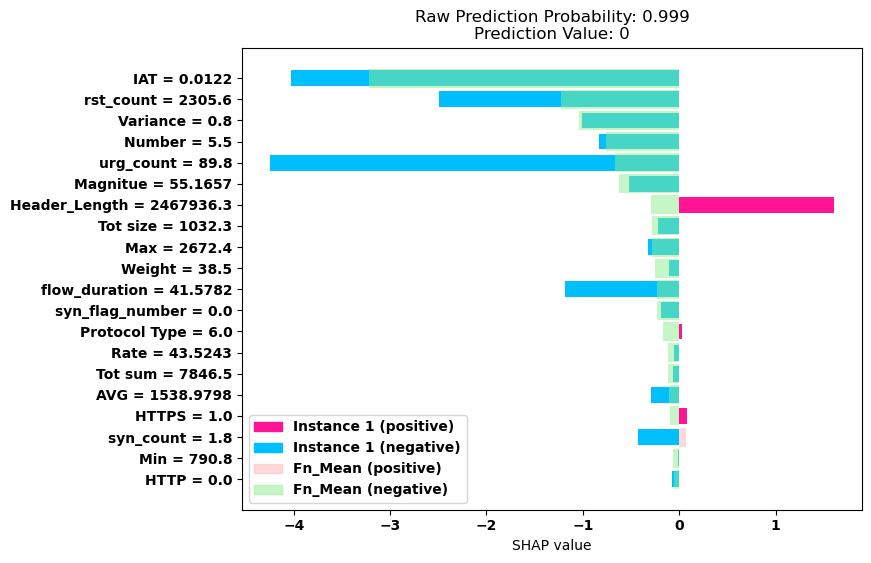

------------------------------------------------------------------------------------------------------------------------------------------------------


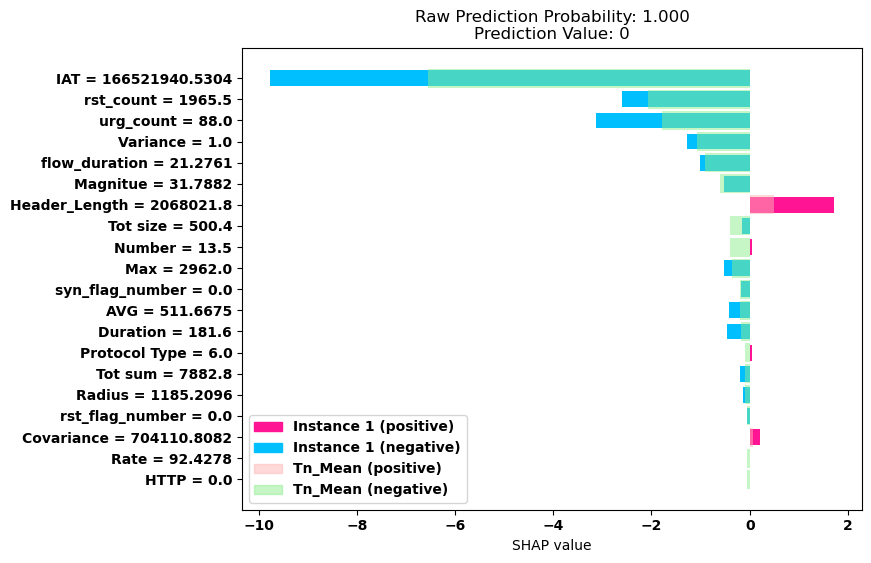

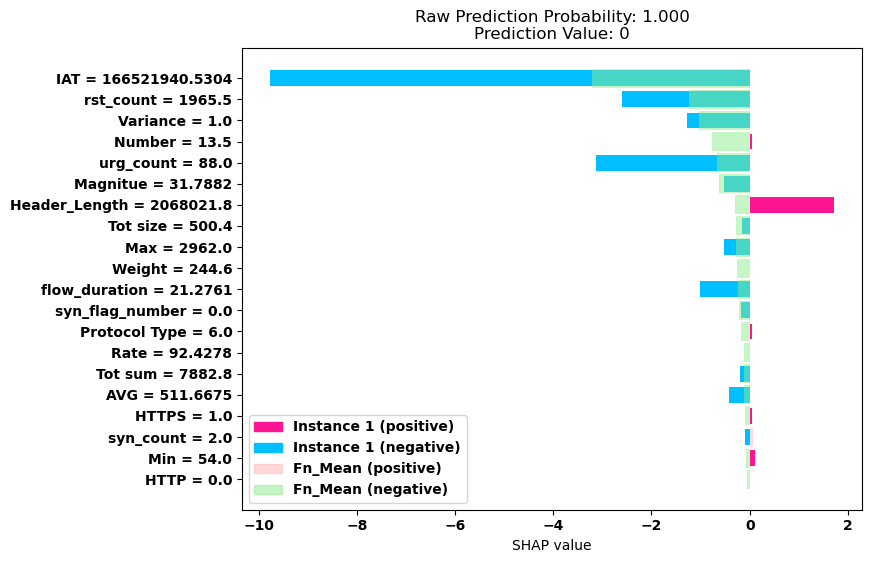

In [ ]:
for i in range(10):
    print('-'*150)
    rand_idx = random.choice(tn_instances)
    tn_random_case = explainer(X_test[rand_idx])
    # print(np.abs(tn_random_case.values))
    plot_overlapping_shap(tn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'Tn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(tn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'TN_Mean')
    plot_overlapping_shap(tn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], tn_random_case.data[fn_top_20_features], 'Fn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(tn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], tn_random_case.data[fn_top_20_features], 'FN_Mean')
    plt.rcParams["figure.figsize"] = (8,6)
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
    plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------


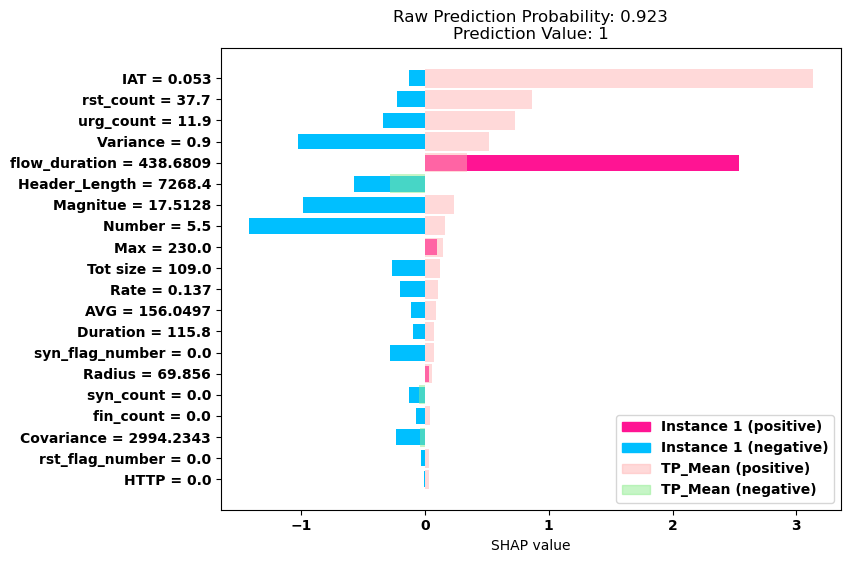

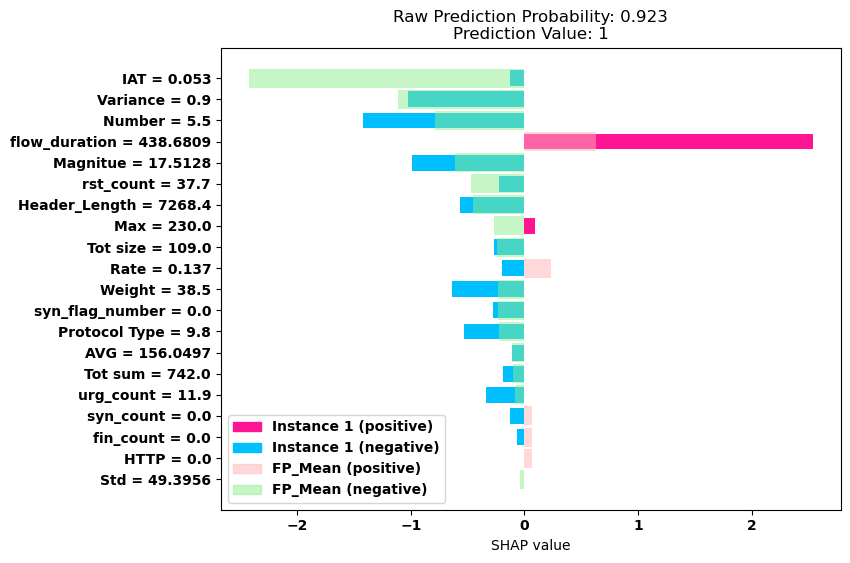

------------------------------------------------------------------------------------------------------------------------------------------------------


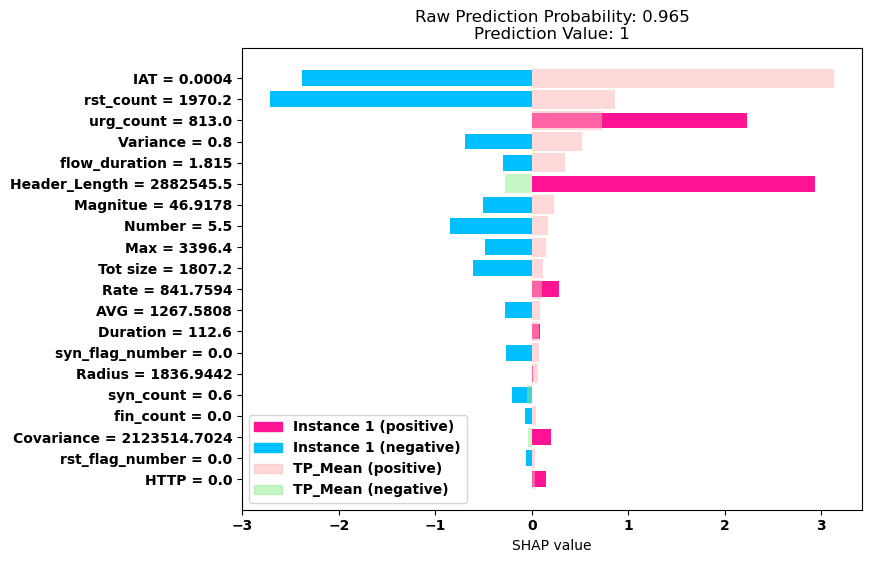

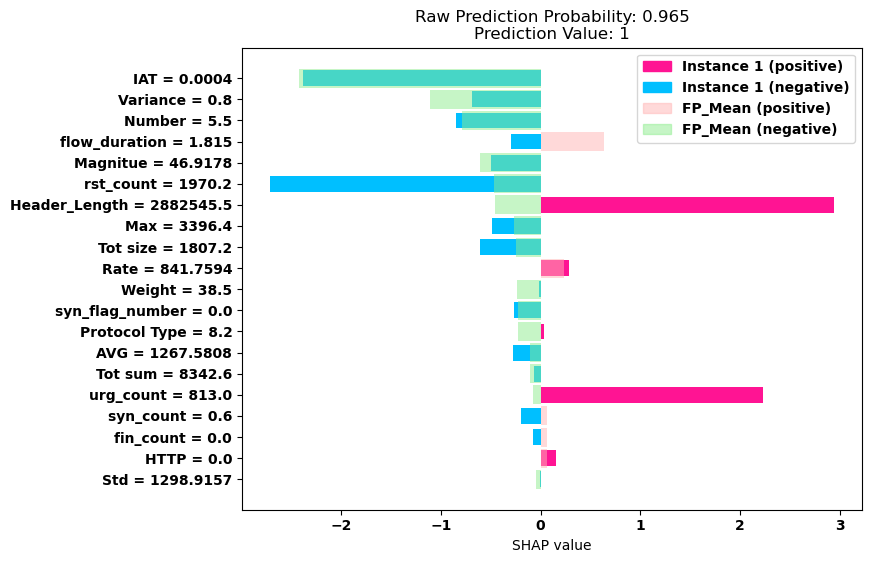

------------------------------------------------------------------------------------------------------------------------------------------------------


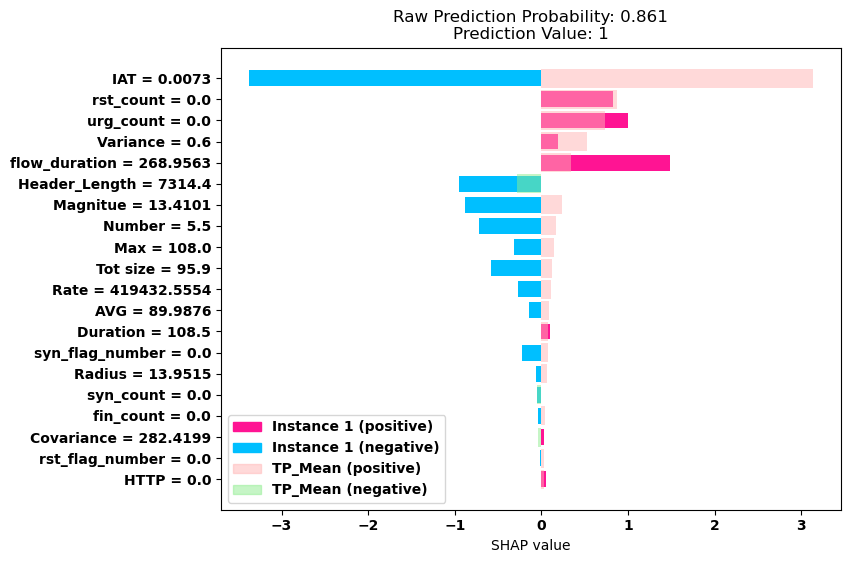

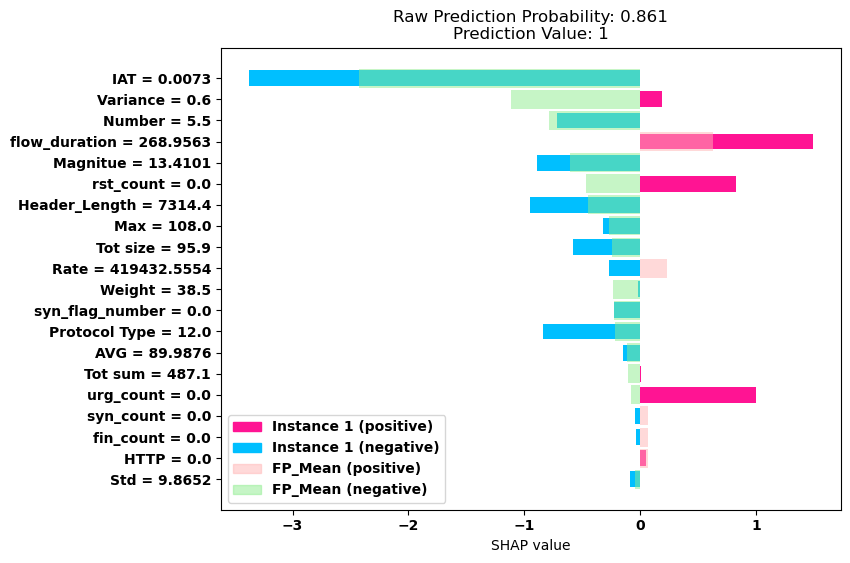

------------------------------------------------------------------------------------------------------------------------------------------------------


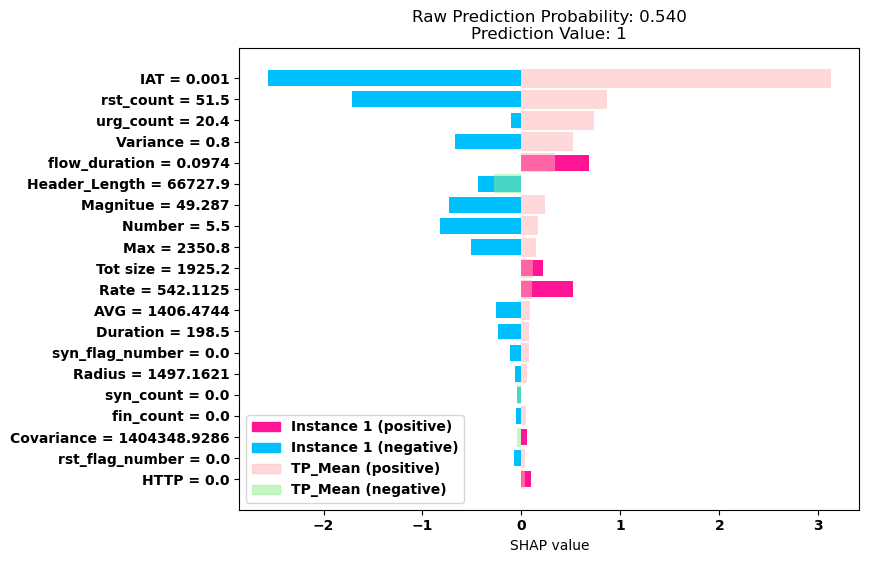

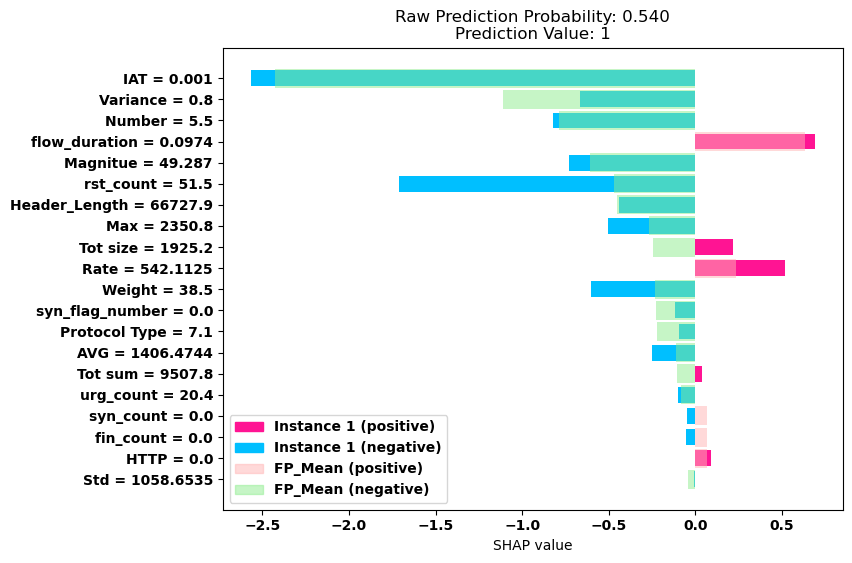

------------------------------------------------------------------------------------------------------------------------------------------------------


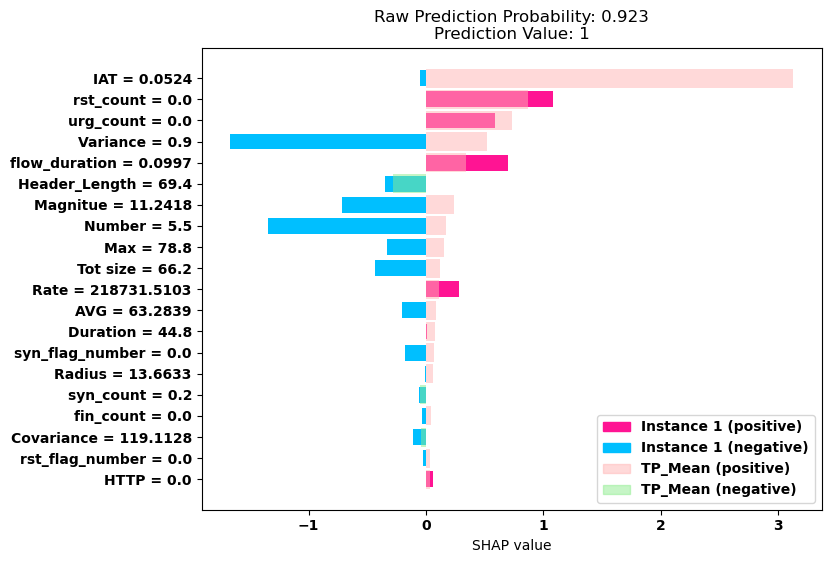

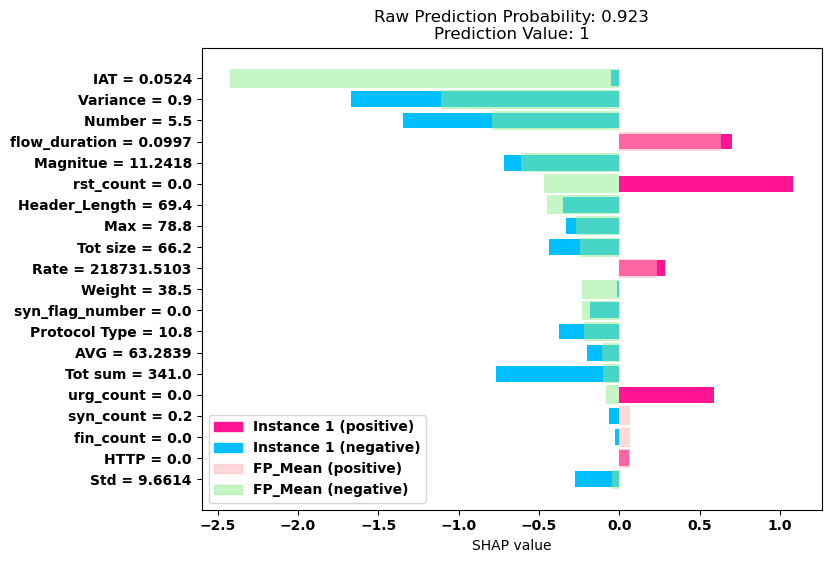

------------------------------------------------------------------------------------------------------------------------------------------------------


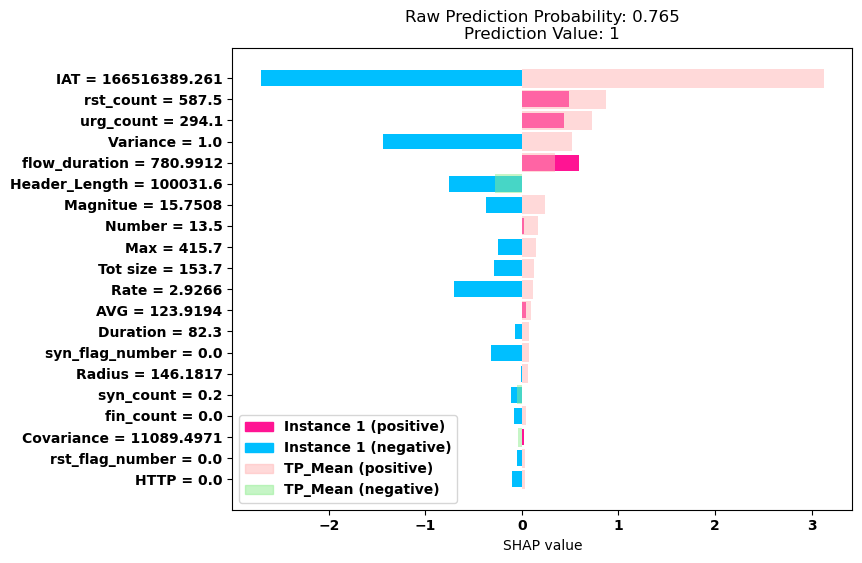

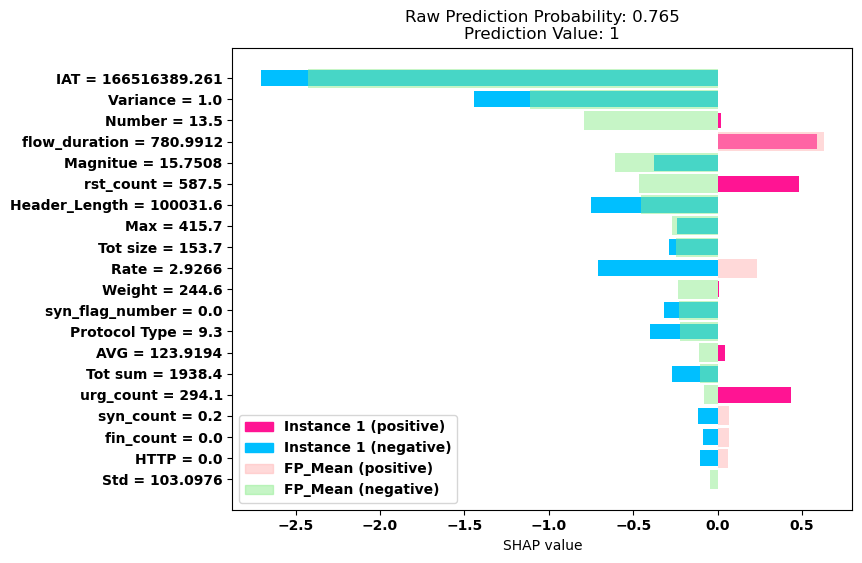

------------------------------------------------------------------------------------------------------------------------------------------------------


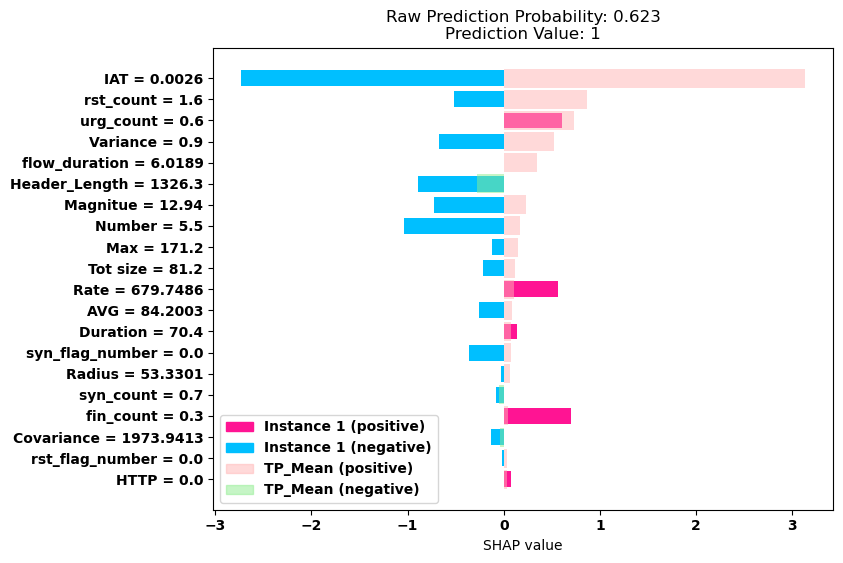

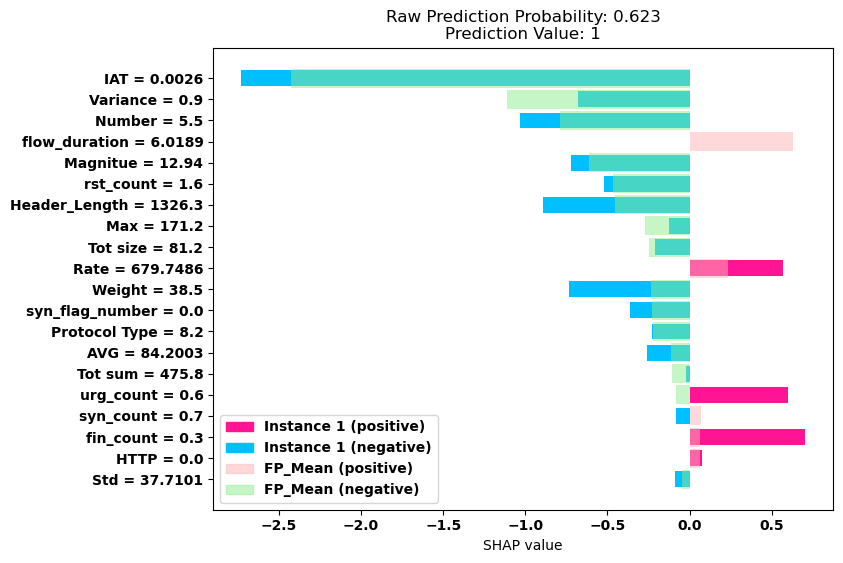

------------------------------------------------------------------------------------------------------------------------------------------------------


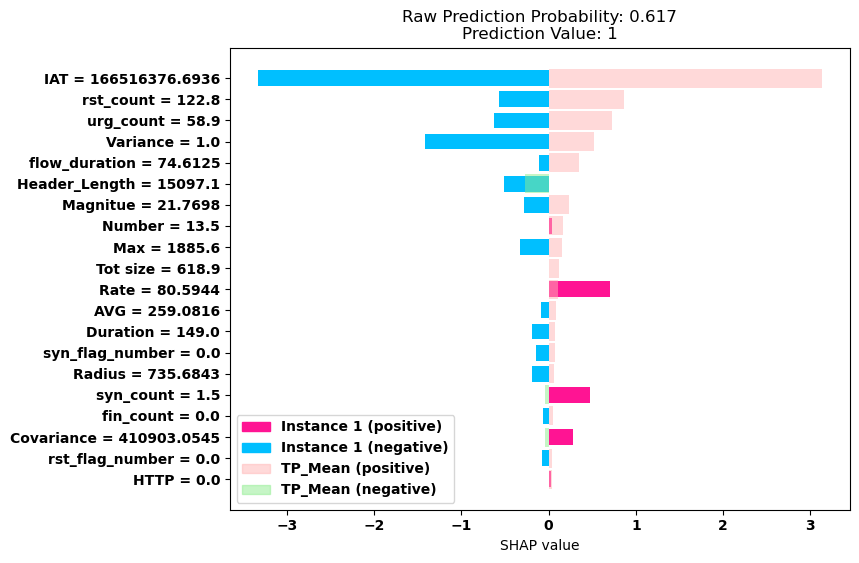

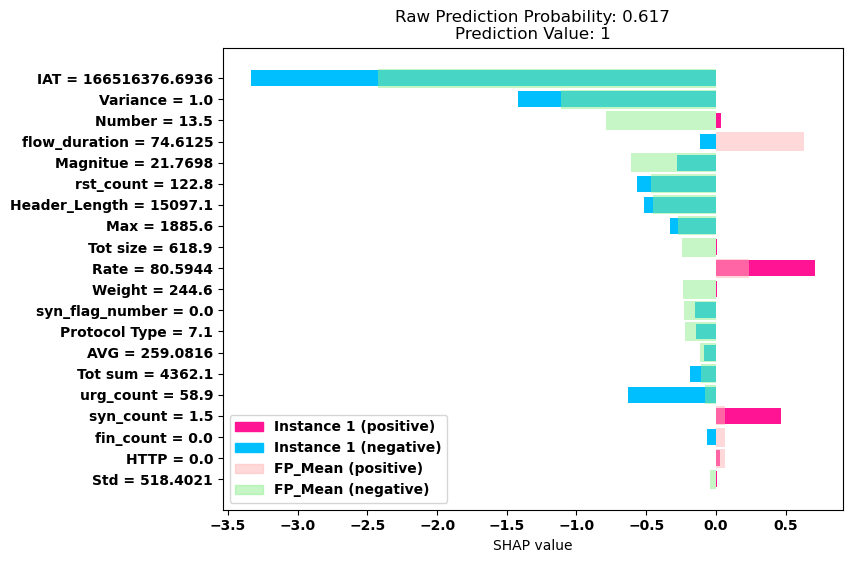

------------------------------------------------------------------------------------------------------------------------------------------------------


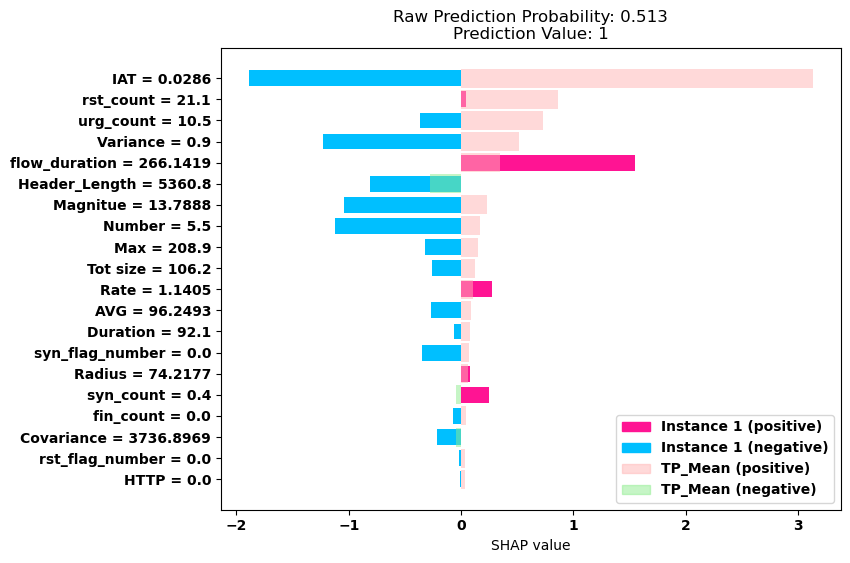

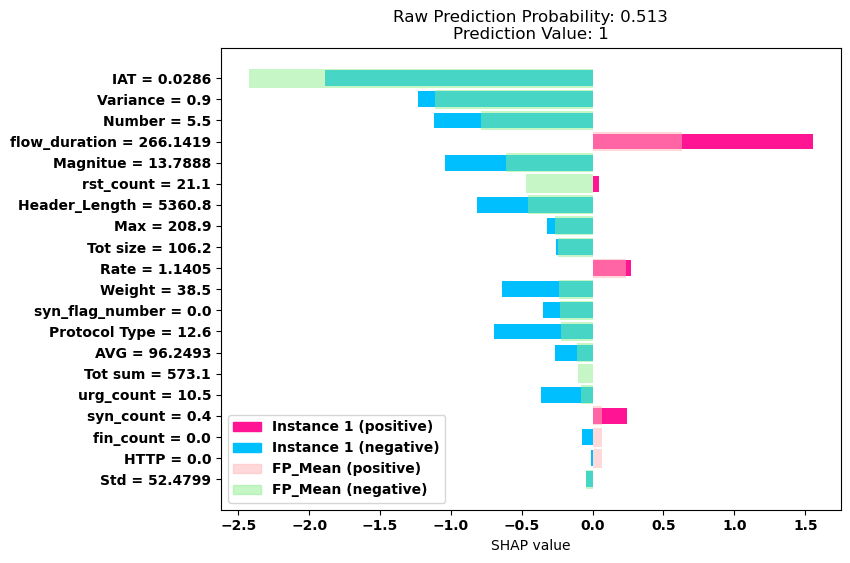

------------------------------------------------------------------------------------------------------------------------------------------------------


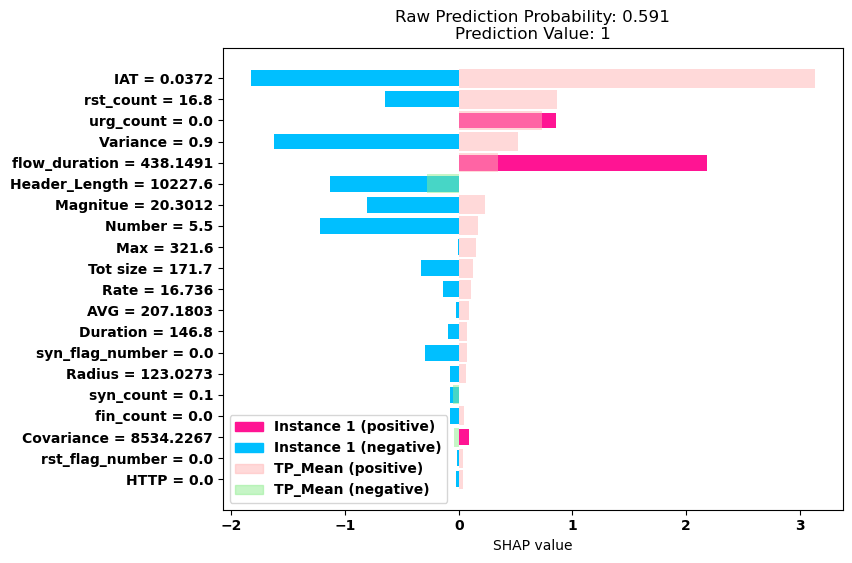

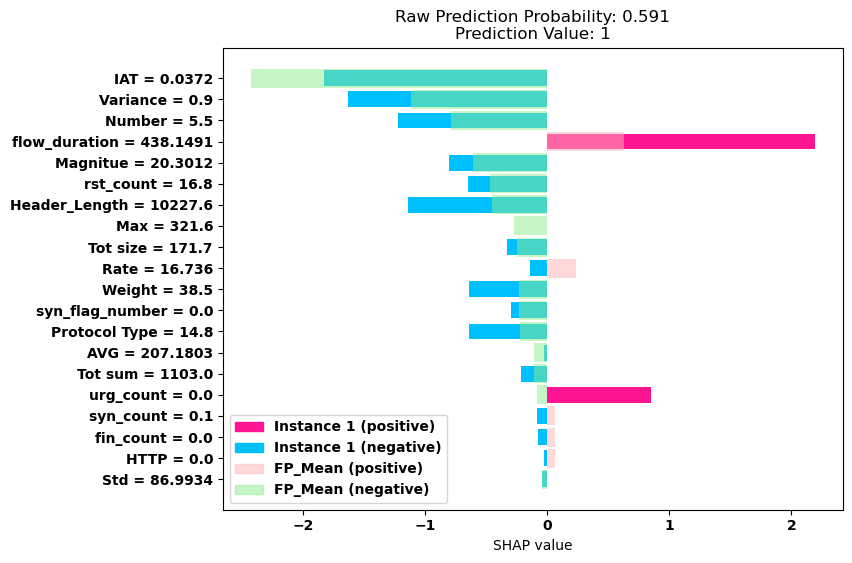

In [ ]:
for i in range(10):
    print('-'*150)
    rand_idx = random.choice(fp_instances)
    fp_random_case = explainer(X_test[rand_idx])
    # print(np.abs(fp_random_case.values))
    plot_overlapping_shap(fp_random_case.values[tp_top_20_features], tp_shap_values_mean[tp_top_20_features], feature_names[tp_top_20_features], fp_random_case.data[tp_top_20_features], 'TP_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(fp_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'TN_Mean')
    plot_overlapping_shap(fp_random_case.values[fp_top_20_features], fp_shap_values_mean[fp_top_20_features], feature_names[fp_top_20_features], fp_random_case.data[fp_top_20_features], 'FP_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(fp_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'FN_Mean')
    plt.rcParams["figure.figsize"] = (8,6)
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
    plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------


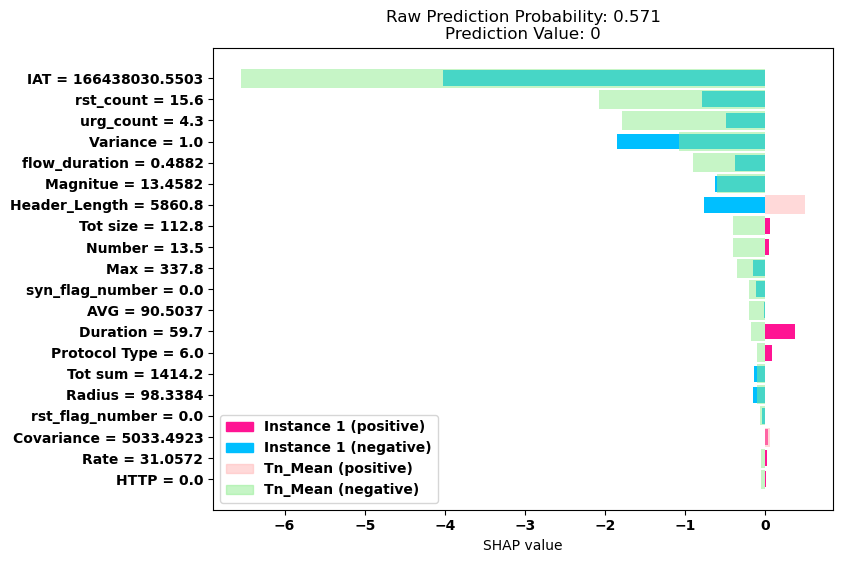

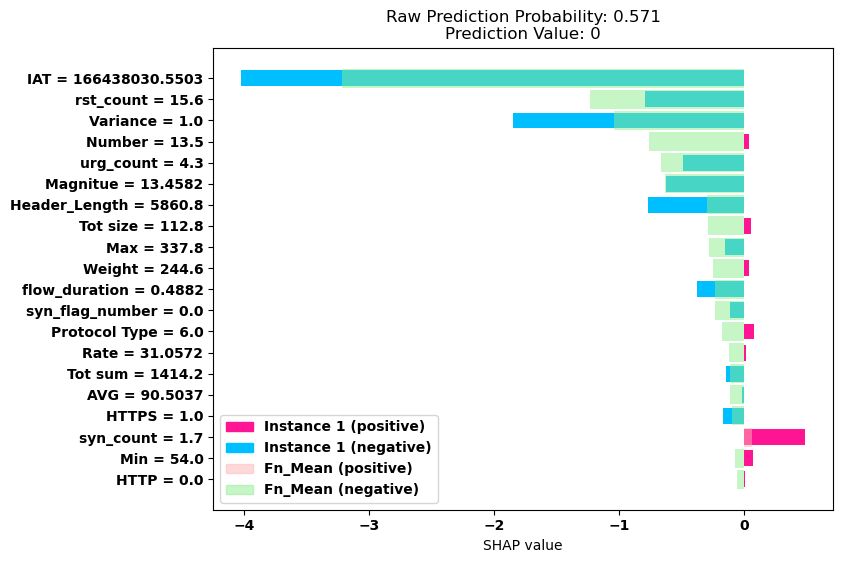

------------------------------------------------------------------------------------------------------------------------------------------------------


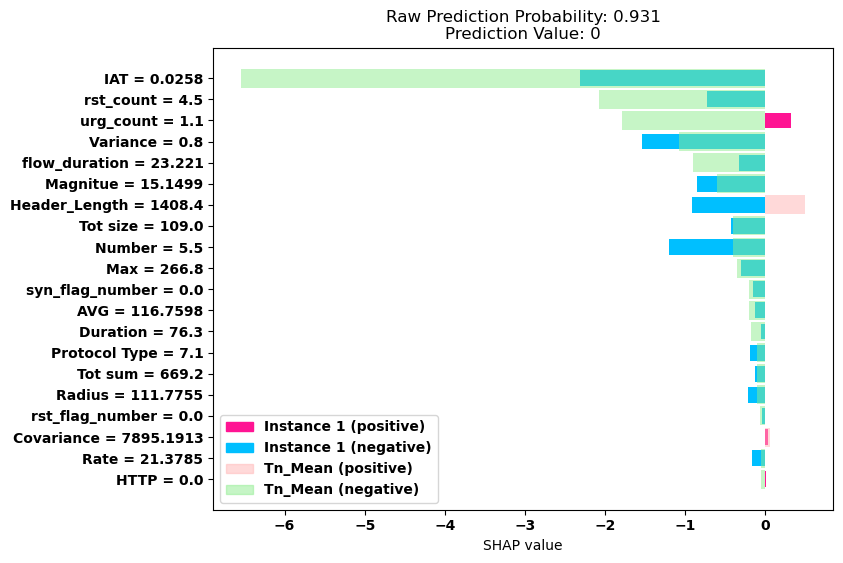

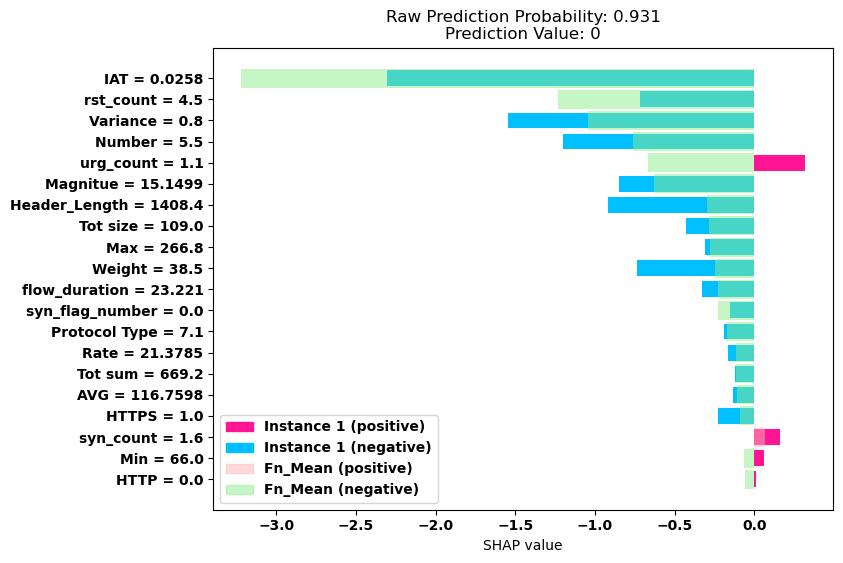

------------------------------------------------------------------------------------------------------------------------------------------------------


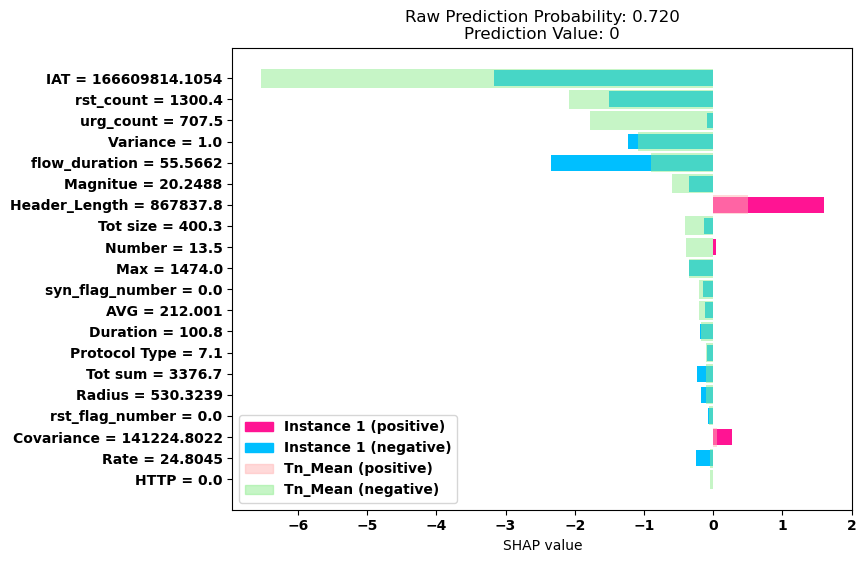

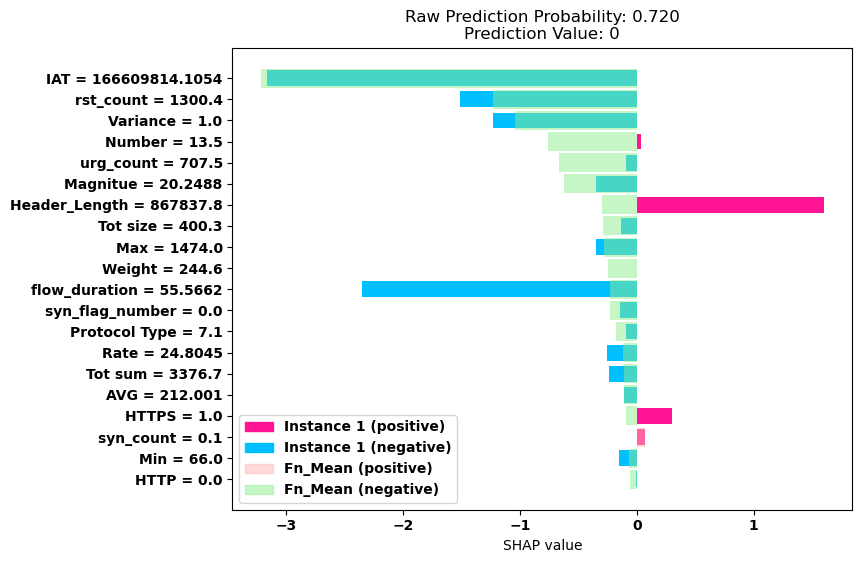

------------------------------------------------------------------------------------------------------------------------------------------------------


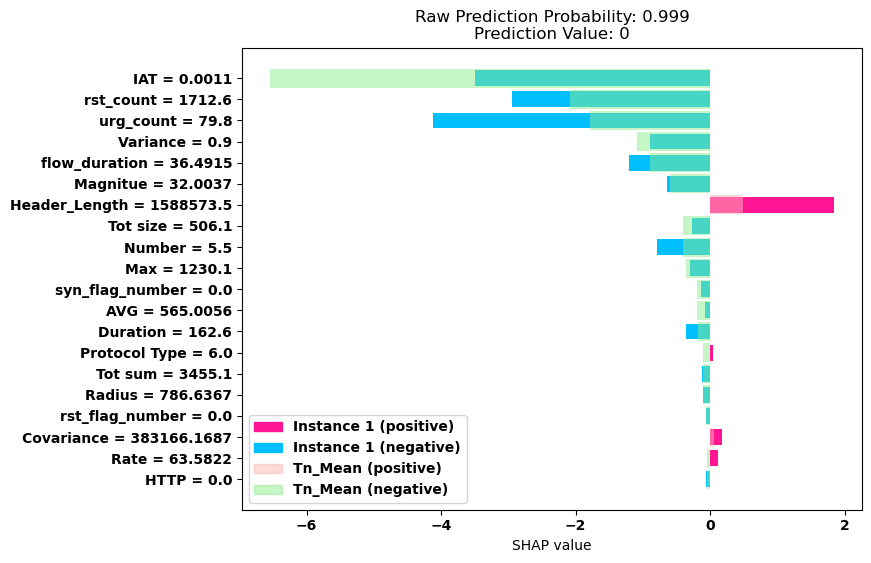

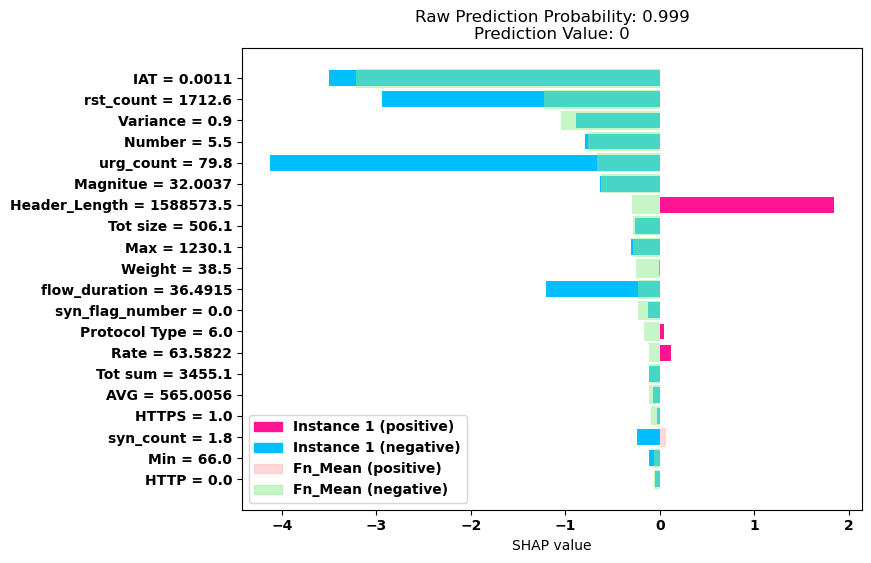

------------------------------------------------------------------------------------------------------------------------------------------------------


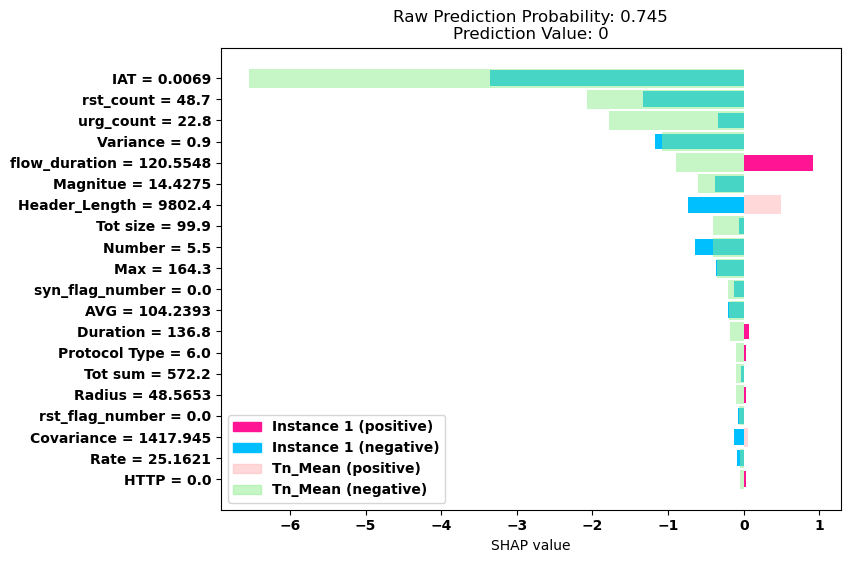

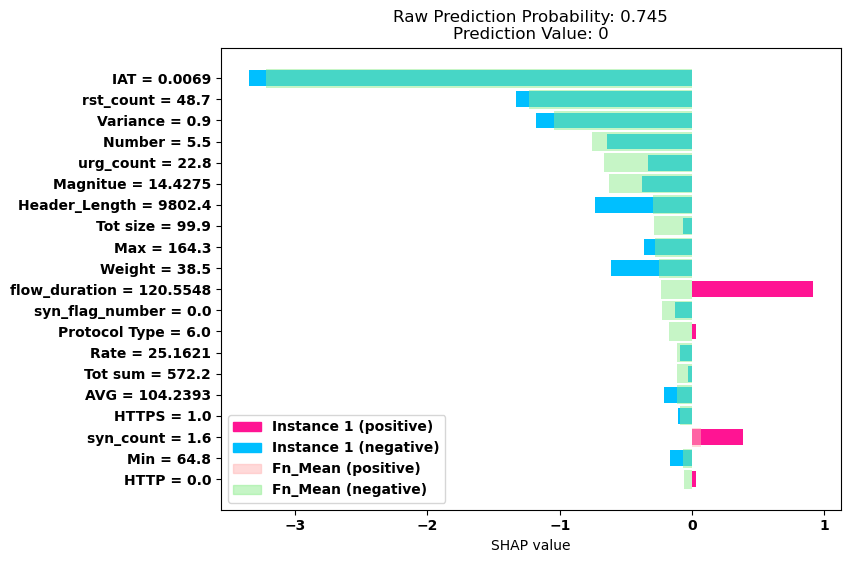

------------------------------------------------------------------------------------------------------------------------------------------------------


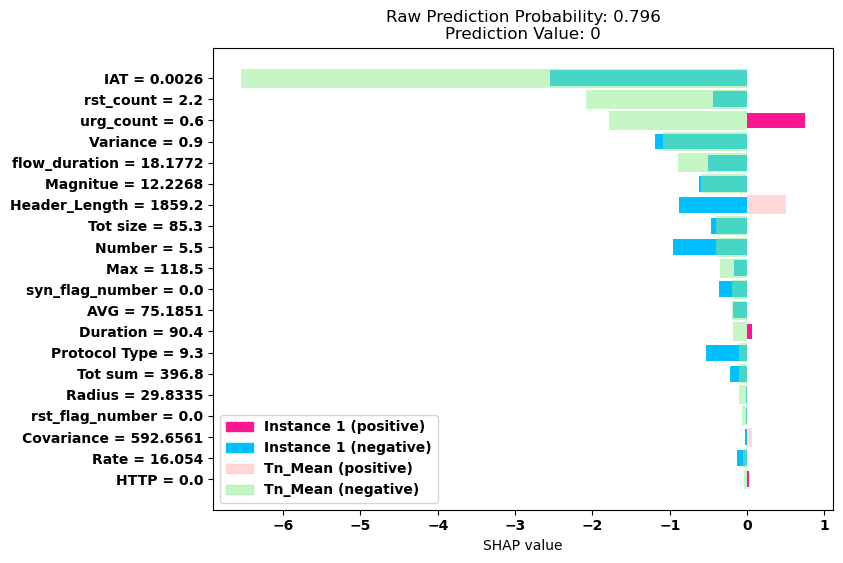

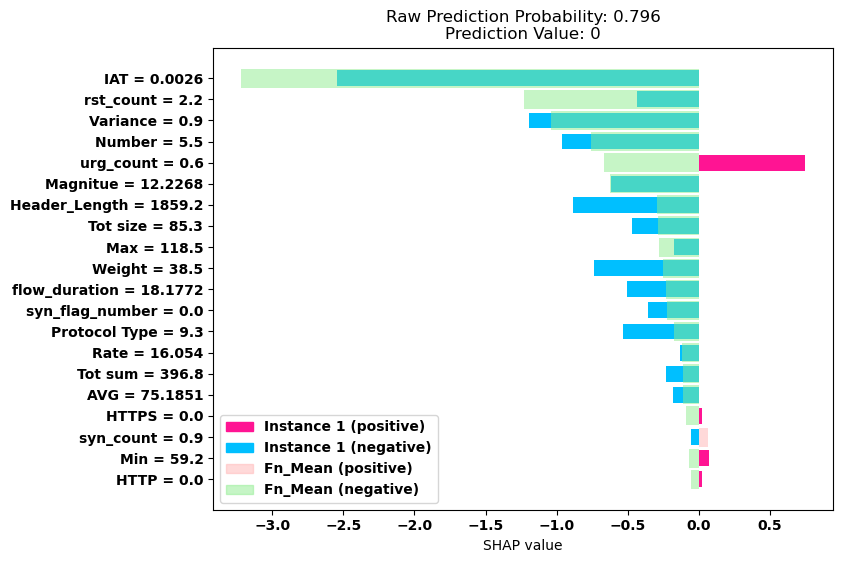

------------------------------------------------------------------------------------------------------------------------------------------------------


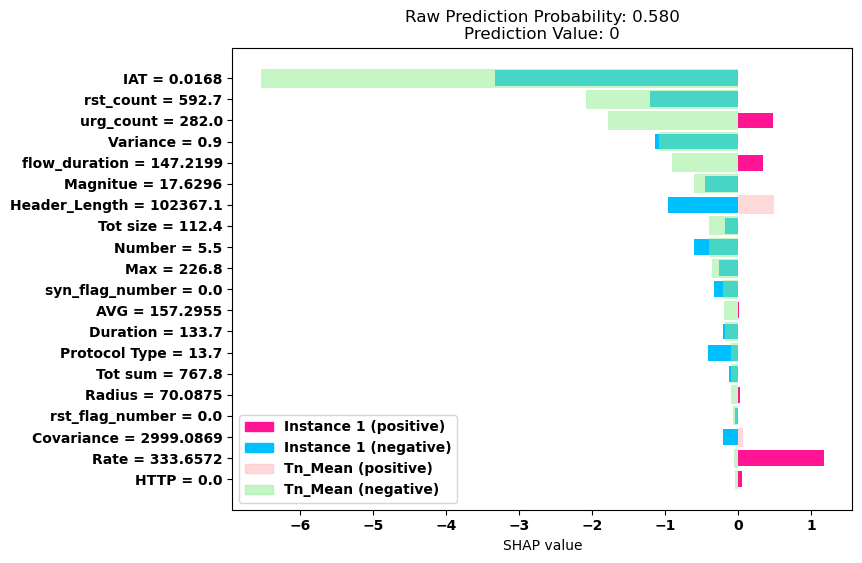

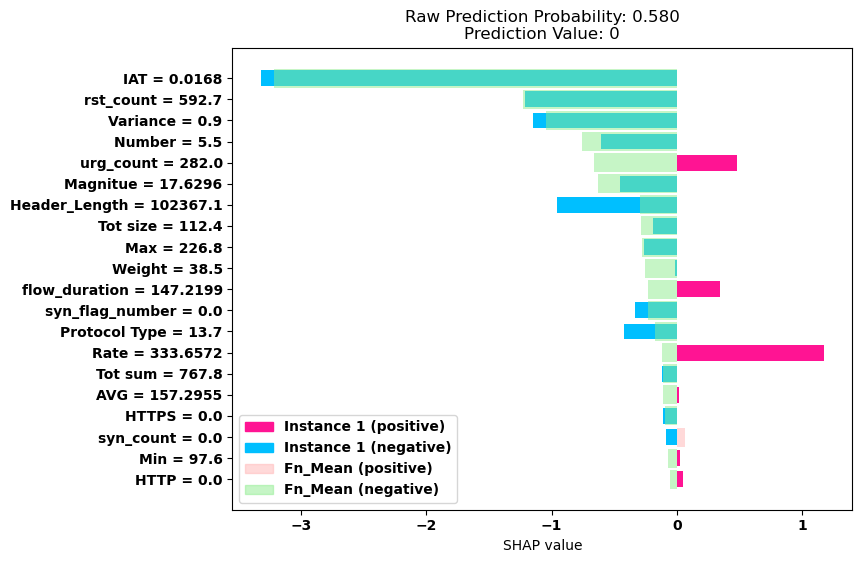

------------------------------------------------------------------------------------------------------------------------------------------------------


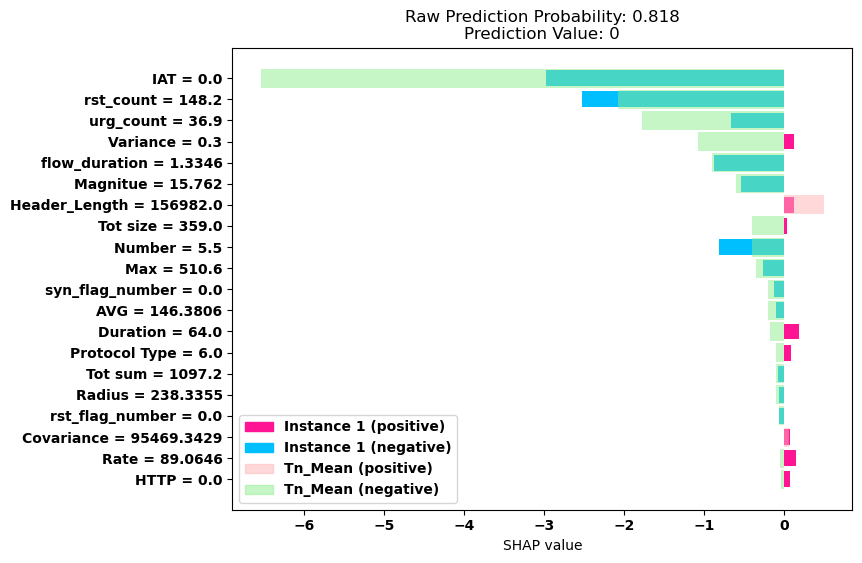

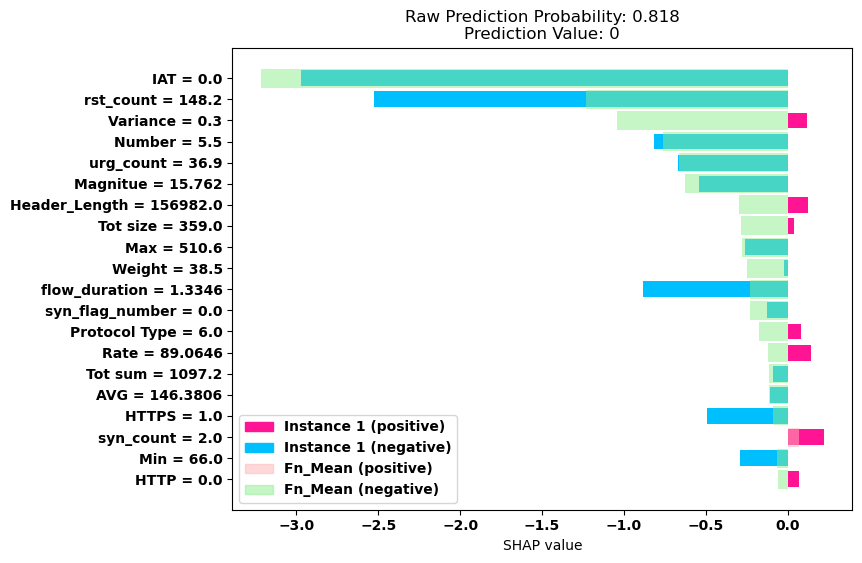

------------------------------------------------------------------------------------------------------------------------------------------------------


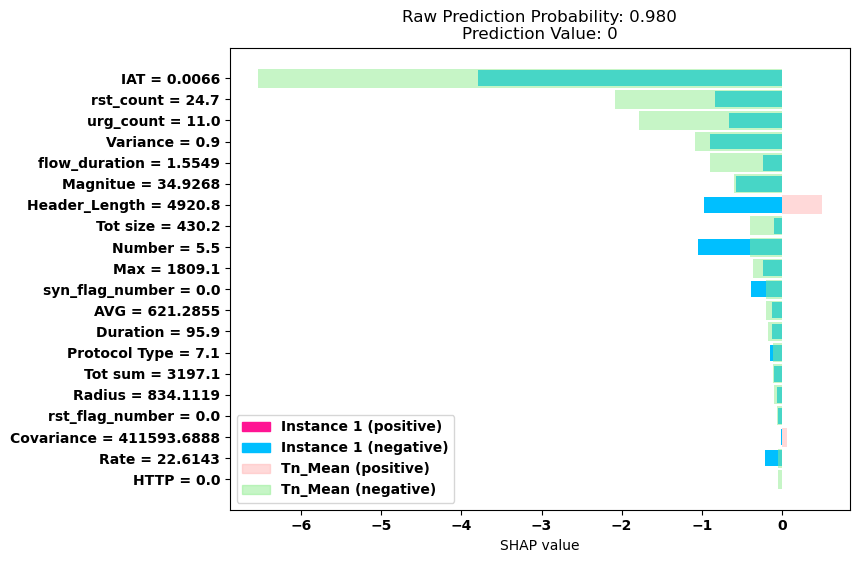

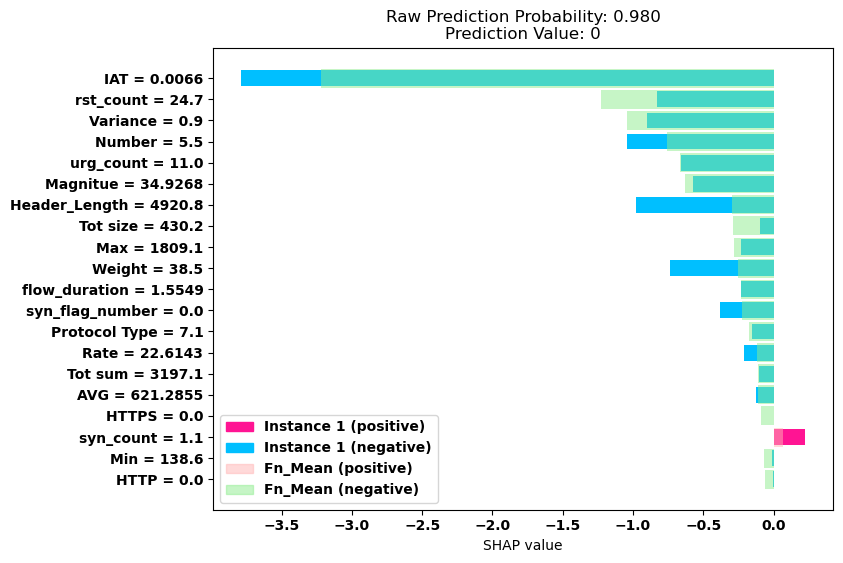

------------------------------------------------------------------------------------------------------------------------------------------------------


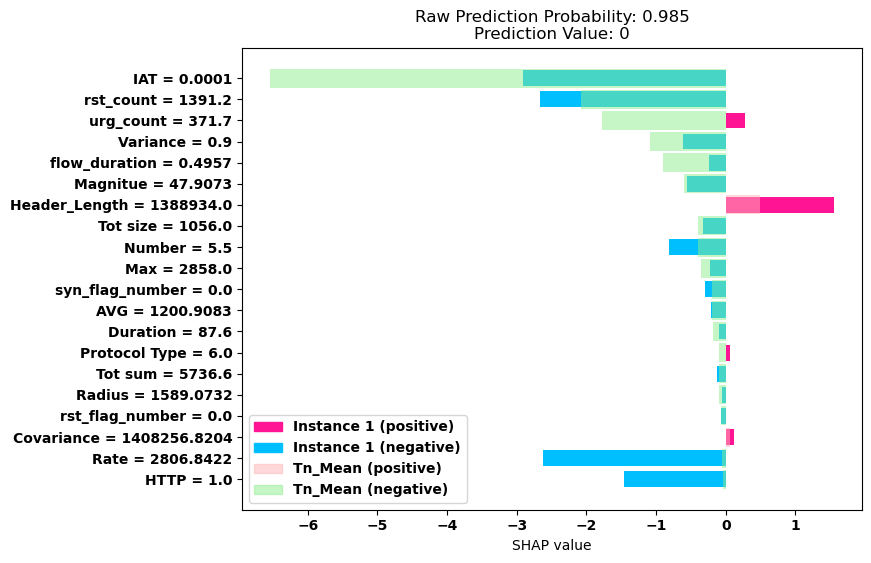

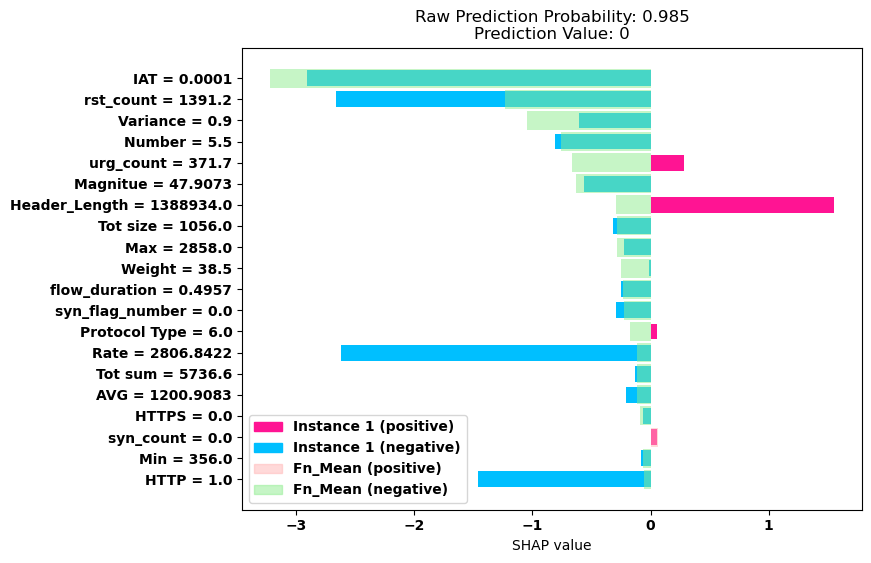

In [ ]:
for i in range(10):
    print('-'*150)
    rand_idx = random.choice(fn_instances)
    fn_random_case = explainer(X_test[rand_idx])
    # print(np.abs(fn_random_case.values))
    plot_overlapping_shap(fn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], fn_random_case.data[tn_top_20_features], 'Tn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(fn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'TN_Mean')
    plot_overlapping_shap(fn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'Fn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    # plot_overlapping_shap(fn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'FN_Mean')
    plt.rcParams["figure.figsize"] = (8,6)
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 10,'font.weight':'bold'})
    plt.show()

In [ ]:
tp_tn_random_size = 35
fp_fn_random_size = 15

random_35_tp_instances = np.random.choice(tp_instances, size=tp_tn_random_size, replace=False)
random_35_tn_instances = np.random.choice(tn_instances, size=tp_tn_random_size, replace=False)
random_15_fp_instances = np.random.choice(fp_instances, size=min(fp_fn_random_size, len(fp_instances)), replace=False)
random_15_fn_instances = np.random.choice(fn_instances, size=min(fp_fn_random_size, len(fn_instances)), replace=False)

print(random_35_tp_instances)
print(random_35_tn_instances)
print(random_15_fp_instances)
print(random_15_fn_instances)

[ 55002 400886 321397 130240 284918  43056 392177  46179 416675 120120
 327552 241387 128613 323739 206210 261148 117482 229074  57090 403475
 146803  16584 327024 437988 315879 352752 262016 179444 171229 191914
 303851 174072 286304  85069 313572]
[175445 324850 133854  96573 298886  17132 280268 316516  75155 400292
 143129 252142 363691 227074 253188 421614 180782 437044 273125 270444
   7011  90831  21330 294363 249707 392826 170602  25696 196041 208410
 335879 352770  33932 150482  16073]
[385085  40082 228605 238715 221750 196786 148832 410727  84719  10078
  84318 231829 193748 323414  16964]
[274326 214871  34844 212925 292962 187063 392389  15664 199959 227014
 212489 143850 276904 335257 201786]


In [ ]:
# [ 55002 400886 321397 130240 284918  43056 392177  46179 416675 120120
#  327552 241387 128613 323739 206210 261148 117482 229074  57090 403475
#  146803  16584 327024 437988 315879 352752 262016 179444 171229 191914
#  303851 174072 286304  85069 313572]
# [175445 324850 133854  96573 298886  17132 280268 316516  75155 400292
#  143129 252142 363691 227074 253188 421614 180782 437044 273125 270444
#    7011  90831  21330 294363 249707 392826 170602  25696 196041 208410
#  335879 352770  33932 150482  16073]
# [385085  40082 228605 238715 221750 196786 148832 410727  84719  10078
#   84318 231829 193748 323414  16964]
# [274326 214871  34844 212925 292962 187063 392389  15664 199959 227014
#  212489 143850 276904 335257 201786]

In [ ]:
for i in random_15_fn_instances:
    rand_idx = i
    fn_random_case = explainer(X_test[rand_idx])

    plot_overlapping_shap(fn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], fn_random_case.data[tn_top_20_features], 'Tn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_tn_compare.png')
    plt.close()
    plot_overlapping_shap(fn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], fn_random_case.data[fn_top_20_features], 'Fn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_fn_compare.png')
    plt.close()

In [ ]:
for i in random_35_tn_instances:
    rand_idx = i
    tn_random_case = explainer(X_test[rand_idx])

    plot_overlapping_shap(tn_random_case.values[tn_top_20_features], tn_shap_values_mean[tn_top_20_features], feature_names[tn_top_20_features], tn_random_case.data[tn_top_20_features], 'Tn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_tn_compare.png')
    plt.close()
    plot_overlapping_shap(tn_random_case.values[fn_top_20_features], fn_shap_values_mean[fn_top_20_features], feature_names[fn_top_20_features], tn_random_case.data[fn_top_20_features], 'Fn_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_fn_compare.png')
    plt.close()

In [ ]:
for i in random_15_fp_instances:
    rand_idx = i
    fp_random_case = explainer(X_test[rand_idx])

    plot_overlapping_shap(fp_random_case.values[tp_top_20_features], tp_shap_values_mean[tp_top_20_features], feature_names[tp_top_20_features], fp_random_case.data[tp_top_20_features], 'Tp_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_tp_compare.png')
    plt.close()
    plot_overlapping_shap(fp_random_case.values[fp_top_20_features], fp_shap_values_mean[fp_top_20_features], feature_names[fp_top_20_features], fp_random_case.data[fp_top_20_features], 'Fp_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_fp_compare.png')
    plt.close()

In [ ]:
for i in random_35_tp_instances:
    rand_idx = i
    tp_random_case = explainer(X_test[rand_idx])

    plot_overlapping_shap(tp_random_case.values[tp_top_20_features], tp_shap_values_mean[tp_top_20_features], feature_names[tp_top_20_features], tp_random_case.data[tp_top_20_features], 'Tp_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_tp_compare.png')
    plt.close()
    plot_overlapping_shap(tp_random_case.values[fp_top_20_features], fp_shap_values_mean[fp_top_20_features], feature_names[fp_top_20_features], tp_random_case.data[fp_top_20_features], 'Fp_Mean', raw_prediction_prob=y_prob[rand_idx], pred_val=xgb_predicted_values[rand_idx])
    plt.savefig('../Images/CIC_IOT_2023/'+str(i)+'_fp_compare.png')
    plt.close()